## Zillow Time Series Data

Target audience: Chicago area short term investor making a profit within 6-months. We are building a model which predicts the 4-6 month range. 

## Import libraries

In [229]:
# !pip install mpld3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import mpld3
from mpld3 import plugins

### Load in data from csv file

In [164]:
zillow_df = pd.read_csv('../data/raw/zillow_data.csv')

In [165]:
zillow_df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [167]:
len(zillow_df['City'].unique())

7554

### Filter for the city of Chicago. 

In [168]:
chicago_df = zillow_df[zillow_df['City']=='Chicago']

In [169]:
zillow_dates = chicago_df[chicago_df.columns[7:]]
zillow_dates.head()

1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10  \
0   334200.0  335400.0  336500.0  337600.0  338500.0  339500.0  340400.0   
3   498100.0  500900.0  503100.0  504600.0  505500.0  505700.0  505300.0   
7   216500.0  216700.0  216900.0  217000.0  217100.0  217200.0  217500.0   
16  122700.0  122800.0  122800.0  122700.0  122400.0  122000.0  121500.0   
19  142600.0  143100.0  143400.0  143300.0  142900.0  142200.0  141300.0   

     1996-11   1996-12   1997-01  ...  2017-07  2017-08  2017-09  2017-10  \
0   341300.0  342600.0  344400.0  ...  1005500  1007500  1007800  1009600   
3   504200.0  503600.0  503400.0  ...  1289800  1287700  1287400  1291500   
7   217900.0  218600.0  219700.0  ...   798000   787100   776100   774900   
16  120900.0  120500.0  120300.0  ...   459600   461400   464300   466500   
19  140100.0  139000.0  138000.0  ...   462700   461200   459900   459200   

    2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0   1013300  1018700  1024400  1030700  1033800  1030600  
3   1296600  1299000  1302700  1306400  1308500  1307000  
7    777900   777900   778500   780500   782800   782800  
16   467900   470600   474500   475100   472600   470200  
19   458700   457900   457400   459000   462500   464300  

[5 rows x 265 columns]

### Transpose the entire dataframe so that the date columns become rows. 

In [170]:
zillow_T = zillow_dates.T
zillow_T.reset_index(inplace=True)

In [171]:
chicago_index = zillow_df.index[zillow_df['City']=='Chicago']
chicago_index

Int64Index([   0,    3,    7,   16,   19,   40,   48,   50,   74,   79,  105,
             150,  157,  215,  231,  284,  318,  324,  332,  347,  497,  638,
             658,  739,  792, 1012, 1360, 1454, 1496, 1727, 1990, 2360, 2420,
            2585, 2830, 3149, 3156, 3960, 4040, 4362, 7863],
           dtype='int64')

In [172]:
chicago_index = chicago_index.astype(str)

### Rename the index column as date

In [173]:
zillow_T.rename(columns={'index':'date'}, inplace=True)
zillow_T.head()

date         0         3         7        16        19        40  \
0  1996-04  334200.0  498100.0  216500.0  122700.0  142600.0  297900.0   
1  1996-05  335400.0  500900.0  216700.0  122800.0  143100.0  300400.0   
2  1996-06  336500.0  503100.0  216900.0  122800.0  143400.0  302600.0   
3  1996-07  337600.0  504600.0  217000.0  122700.0  143300.0  304700.0   
4  1996-08  338500.0  505500.0  217100.0  122400.0  142900.0  306600.0   

        48        50       74  ...      2360      2420      2585      2830  \
0  93400.0  148900.0  76400.0  ...  100900.0  215600.0  165400.0  103700.0   
1  94100.0  149300.0  77000.0  ...  101400.0  215100.0  165300.0  104400.0   
2  94600.0  149600.0  77400.0  ...  101900.0  214500.0  165000.0  104700.0   
3  94800.0  149700.0  77700.0  ...  102300.0  213900.0  164600.0  104700.0   
4  94700.0  149700.0  77700.0  ...  102700.0  213200.0  164100.0  104400.0   

       3149      3156      3960      4040      4362     7863  
0  180900.0  166300.0  125700.0  197300.0  224100.0  77900.0  
1  182200.0  166900.0  126300.0  198900.0  223300.0  78200.0  
2  183100.0  167200.0  126600.0  200100.0  222400.0  78300.0  
3  183500.0  167100.0  126500.0  200800.0  221500.0  78500.0  
4  183400.0  166900.0  126100.0  201000.0  220500.0  78500.0  

[5 rows x 42 columns]

### Change data column to a datetime object

In [174]:
zillow_T['date'] = pd.to_datetime(zillow_T['date'])
# zillow_T.info()

### Grabbed zipcodes from corresponding index

In [175]:
chicago_zips = zillow_df.RegionName.iloc[chicago_index.astype(int)]
chicago_zips.head()

0     60657
3     60614
7     60640
16    60647
19    60618
Name: RegionName, dtype: int64

### Renaming column names from index to zipcodes

In [176]:
zillow_T.columns = ['date']+list(chicago_zips)
zillow_chicago = zillow_T
zillow_chicago.head()

date     60657     60614     60640     60647     60618     60613  \
0 1996-04-01  334200.0  498100.0  216500.0  122700.0  142600.0  297900.0   
1 1996-05-01  335400.0  500900.0  216700.0  122800.0  143100.0  300400.0   
2 1996-06-01  336500.0  503100.0  216900.0  122800.0  143400.0  302600.0   
3 1996-07-01  337600.0  504600.0  217000.0  122700.0  143300.0  304700.0   
4 1996-08-01  338500.0  505500.0  217100.0  122400.0  142900.0  306600.0   

     60629     60625    60619  ...     60612     60607     60659     60652  \
0  93400.0  148900.0  76400.0  ...  100900.0  215600.0  165400.0  103700.0   
1  94100.0  149300.0  77000.0  ...  101400.0  215100.0  165300.0  104400.0   
2  94600.0  149600.0  77400.0  ...  101900.0  214500.0  165000.0  104700.0   
3  94800.0  149700.0  77700.0  ...  102300.0  213900.0  164600.0  104700.0   
4  94700.0  149700.0  77700.0  ...  102700.0  213200.0  164100.0  104400.0   

      60631     60656     60655     60646     60642    60633  
0  180900.0  166300.0  125700.0  197300.0  224100.0  77900.0  
1  182200.0  166900.0  126300.0  198900.0  223300.0  78200.0  
2  183100.0  167200.0  126600.0  200100.0  222400.0  78300.0  
3  183500.0  167100.0  126500.0  200800.0  221500.0  78500.0  
4  183400.0  166900.0  126100.0  201000.0  220500.0  78500.0  

[5 rows x 42 columns]

### Making date column the index

In [177]:
zillow_chicago.set_index('date', inplace=True)

In [178]:
zillow_chicago.head()

60657     60614     60640     60647     60618     60613  \
date                                                                     
1996-04-01  334200.0  498100.0  216500.0  122700.0  142600.0  297900.0   
1996-05-01  335400.0  500900.0  216700.0  122800.0  143100.0  300400.0   
1996-06-01  336500.0  503100.0  216900.0  122800.0  143400.0  302600.0   
1996-07-01  337600.0  504600.0  217000.0  122700.0  143300.0  304700.0   
1996-08-01  338500.0  505500.0  217100.0  122400.0  142900.0  306600.0   

              60629     60625    60619     60610  ...     60612     60607  \
date                                              ...                       
1996-04-01  93400.0  148900.0  76400.0  435200.0  ...  100900.0  215600.0   
1996-05-01  94100.0  149300.0  77000.0  435200.0  ...  101400.0  215100.0   
1996-06-01  94600.0  149600.0  77400.0  435100.0  ...  101900.0  214500.0   
1996-07-01  94800.0  149700.0  77700.0  434600.0  ...  102300.0  213900.0   
1996-08-01  94700.0  149700.0  77700.0  433900.0  ...  102700.0  213200.0   

               60659     60652     60631     60656     60655     60646  \
date                                                                     
1996-04-01  165400.0  103700.0  180900.0  166300.0  125700.0  197300.0   
1996-05-01  165300.0  104400.0  182200.0  166900.0  126300.0  198900.0   
1996-06-01  165000.0  104700.0  183100.0  167200.0  126600.0  200100.0   
1996-07-01  164600.0  104700.0  183500.0  167100.0  126500.0  200800.0   
1996-08-01  164100.0  104400.0  183400.0  166900.0  126100.0  201000.0   

               60642    60633  
date                           
1996-04-01  224100.0  77900.0  
1996-05-01  223300.0  78200.0  
1996-06-01  222400.0  78300.0  
1996-07-01  221500.0  78500.0  
1996-08-01  220500.0  78500.0  

[5 rows x 41 columns]

### Saving the csv file 

In [179]:
zillow_chicago.to_csv('../data/processed/zillow_chicago_1996_to_2018')

After some analysis below, we went back to our original dataframe and decided to use a subset of the years from 2012 onwards. 

### Choosing only certain years

In [182]:
zillow_chicago = zillow_chicago.loc['2013':'2017',:]
zillow_chicago.head()

60657      60614     60640     60647     60618     60613  \
date                                                                      
2013-01-01  802300.0  1006300.0  547400.0  299700.0  324500.0  775200.0   
2013-02-01  806100.0  1013700.0  549900.0  304600.0  327400.0  779800.0   
2013-03-01  810900.0  1024800.0  556700.0  310800.0  331400.0  783000.0   
2013-04-01  817400.0  1038300.0  566800.0  317200.0  336300.0  787300.0   
2013-05-01  826800.0  1053900.0  574000.0  322100.0  341500.0  795700.0   

               60629     60625     60619     60610  ...     60612     60607  \
date                                                ...                       
2013-01-01  113000.0  332100.0  113400.0  813000.0  ...  220700.0  418800.0   
2013-02-01  113300.0  334300.0  111300.0  821500.0  ...  222200.0  420500.0   
2013-03-01  113700.0  338400.0  110600.0  832100.0  ...  223900.0  423500.0   
2013-04-01  114500.0  344300.0  109200.0  841500.0  ...  225600.0  429000.0   
2013-05-01  116000.0  348900.0  107000.0  854600.0  ...  229200.0  432700.0   

               60659     60652     60631     60656     60655     60646  \
date                                                                     
2013-01-01  262800.0  130900.0  268100.0  222900.0  183200.0  317700.0   
2013-02-01  263900.0  131400.0  270200.0  225400.0  183400.0  319800.0   
2013-03-01  266800.0  132000.0  273200.0  229200.0  184700.0  322400.0   
2013-04-01  270100.0  133000.0  277300.0  233400.0  186600.0  325400.0   
2013-05-01  274100.0  134700.0  282000.0  238400.0  188800.0  329100.0   

               60642    60633  
date                           
2013-01-01  424100.0  84600.0  
2013-02-01  426100.0  83800.0  
2013-03-01  429300.0  83000.0  
2013-04-01  434600.0  82100.0  
2013-05-01  441100.0  80600.0  

[5 rows x 41 columns]

## Exploratory Analysis
- Baseline model
	- Staitonarity (e.g. trends, seasonal patterns, cyclical patterns, differencing, Dickey Fuller Test)  
	- ACF
	- PACF
	- At least AR and MA models
	- Evaluation metric  

### Plotting all data prior to detrending

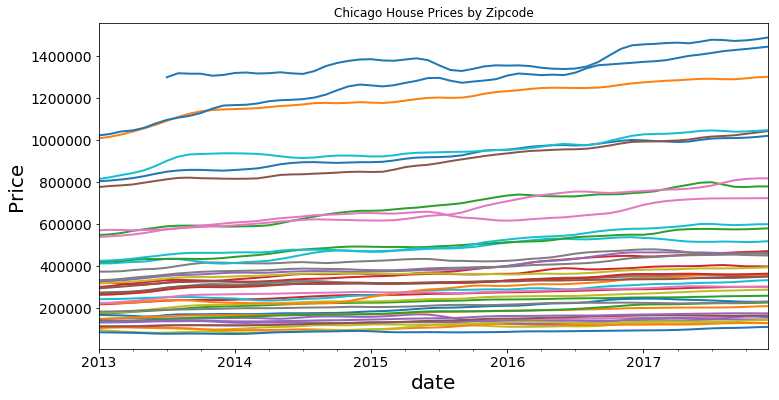

In [17]:
cat = zillow_chicago.plot(figsize=(12,6), linewidth=2, fontsize=14)
plt.xlabel('date', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Chicago House Prices by Zipcode')
cat.legend().remove()


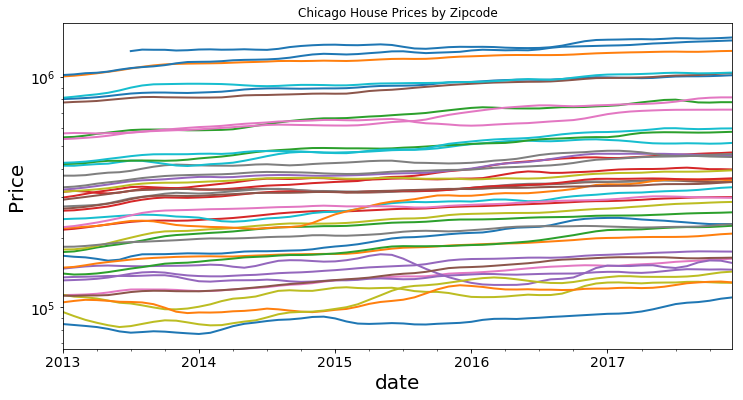

In [183]:
cat = zillow_chicago.plot(figsize=(12,6), linewidth=2, fontsize=14)
plt.xlabel('date', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Chicago House Prices by Zipcode')
cat.legend().remove()
plt.yscale('log')

From the previous plot, we can see there is no seasonality in the data.

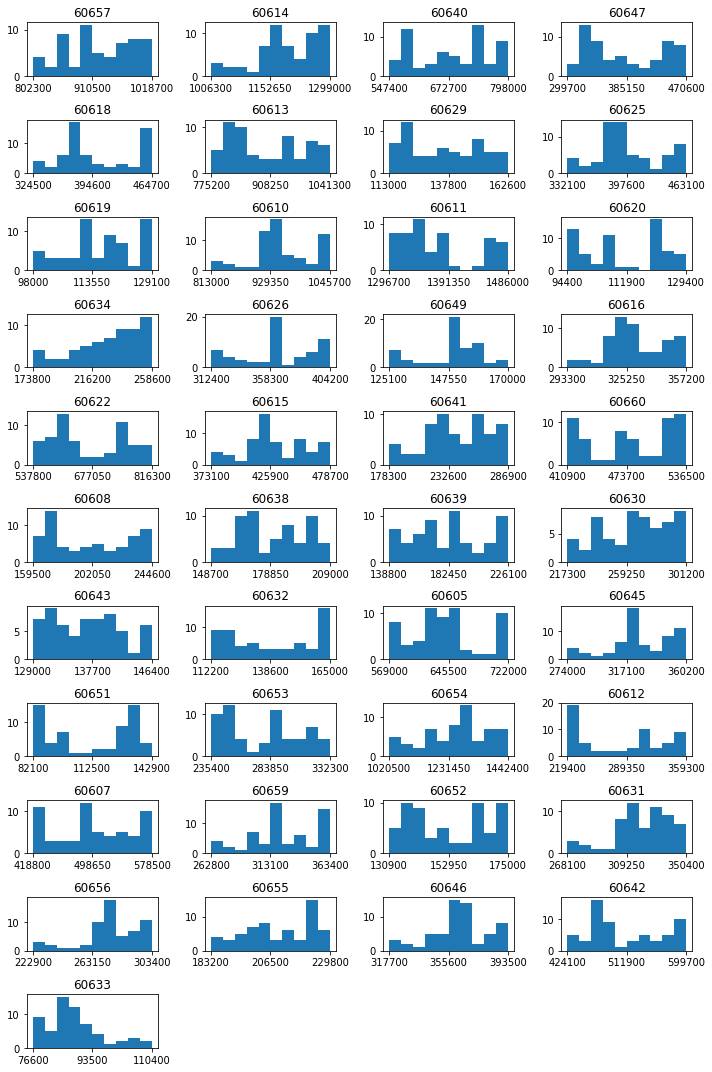

In [259]:
fig=plt.figure(figsize=(10,15))
# ax=plt.subplots(7,7)
for index, zipcode in enumerate(zillow_chicago.columns):
    ax = fig.add_subplot(11,4,index+1)
    h = ax.hist(zillow_chicago[zipcode])
    prices = h[1]
    ax.set_xticks(np.linspace(prices[0], prices[-1], 3))
    ax.set_title(zipcode)

# print(h[1])
plt.tight_layout();
# price and count of where it spent the most time at which price point

In order to run analysis on the zipcode, we need to detrend our data from any trends associated with climate, season, etc. 

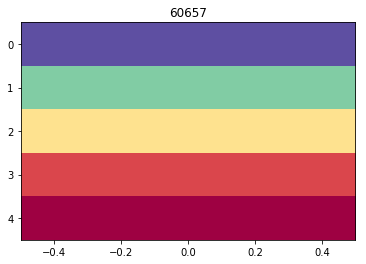

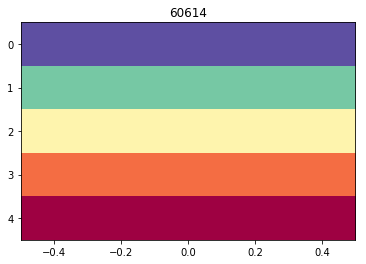

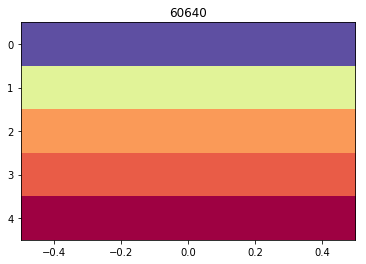

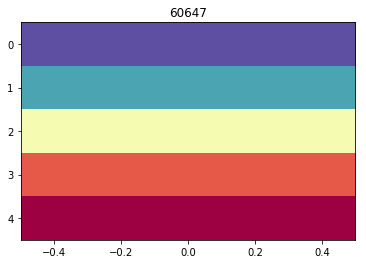

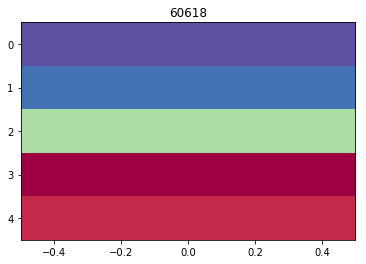

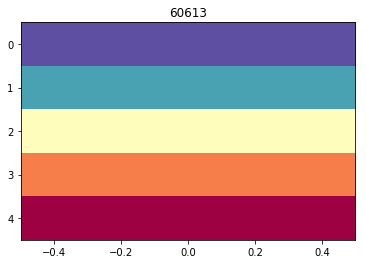

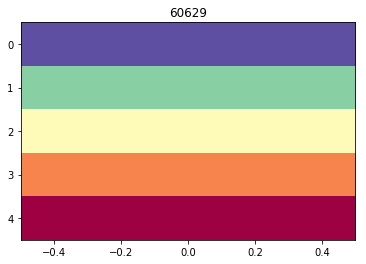

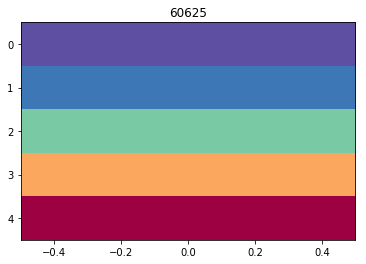

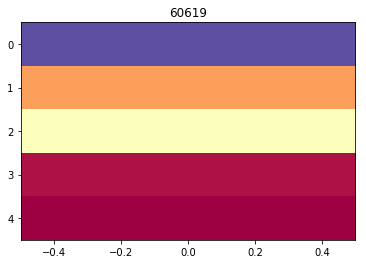

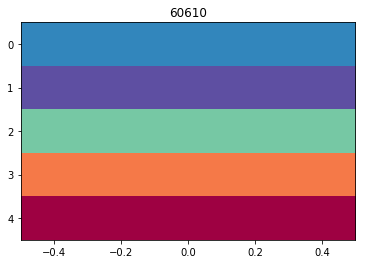

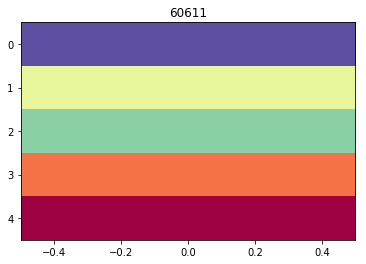

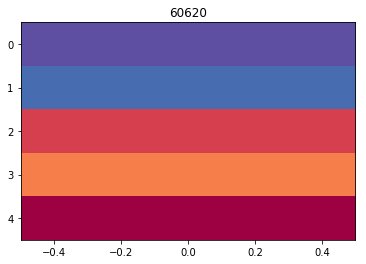

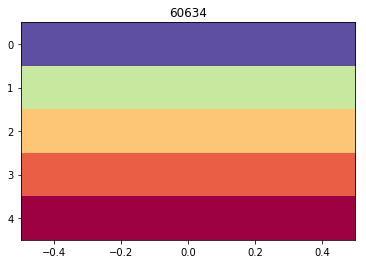

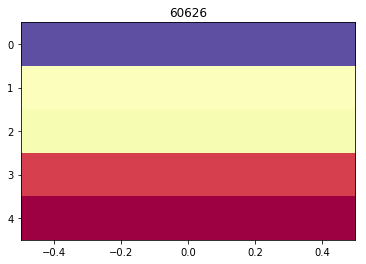

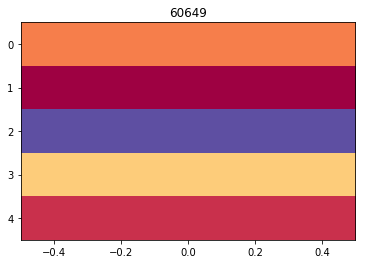

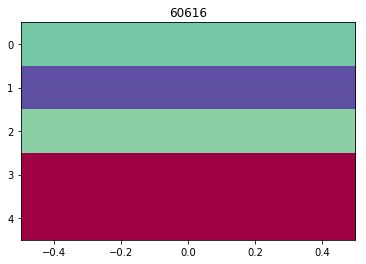

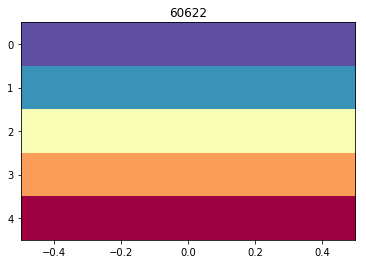

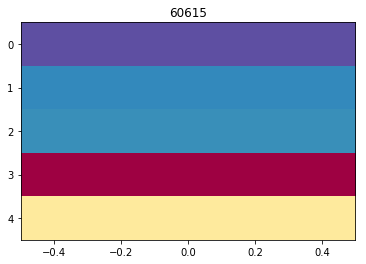

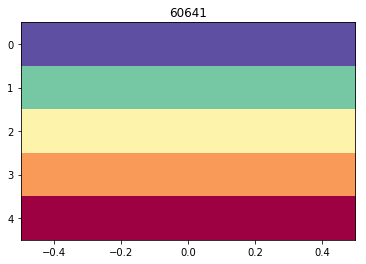

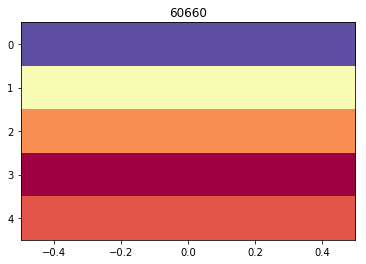

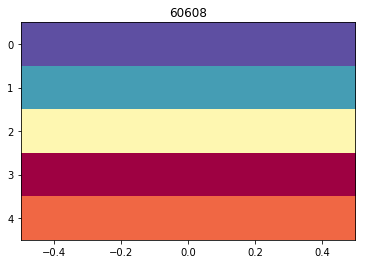

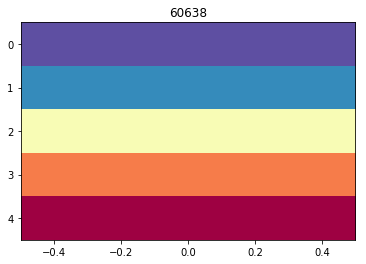

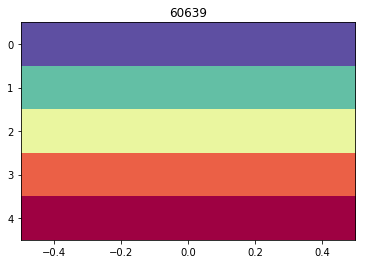

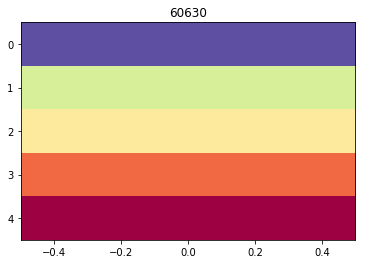

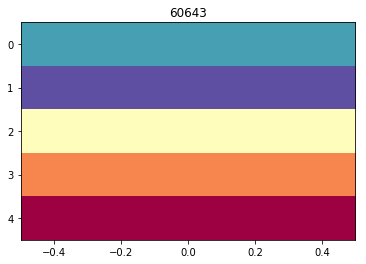

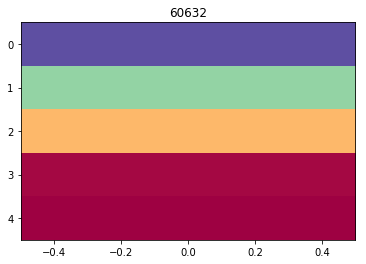

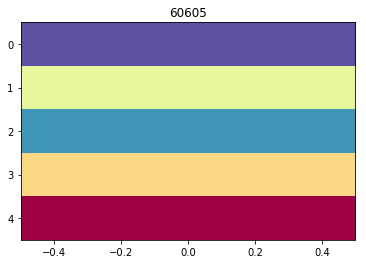

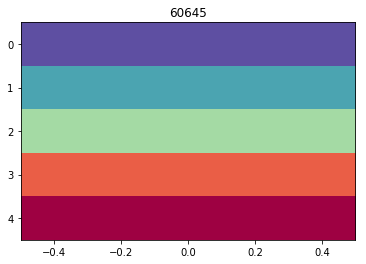

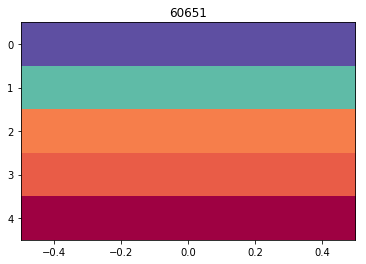

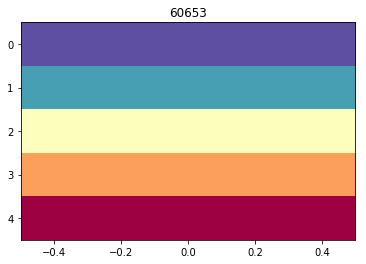

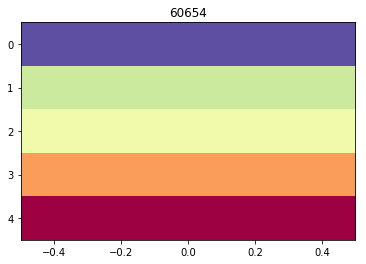

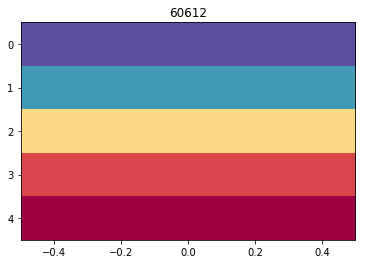

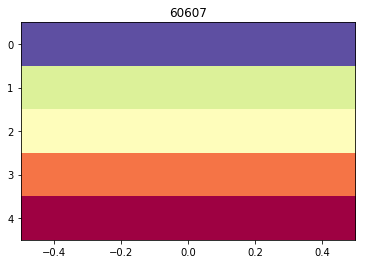

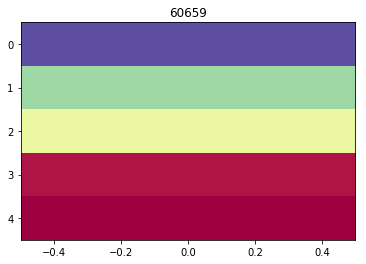

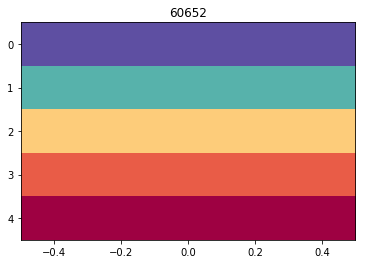

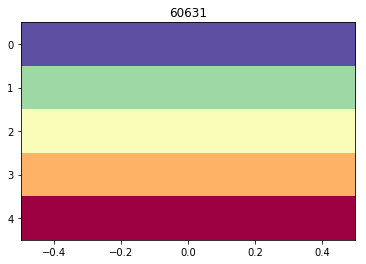

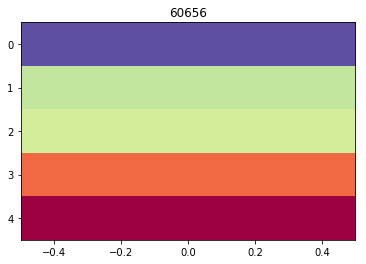

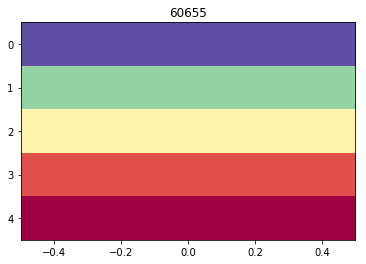

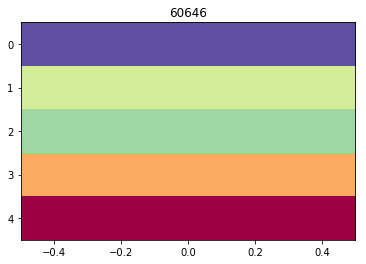

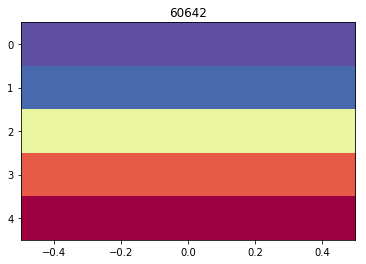

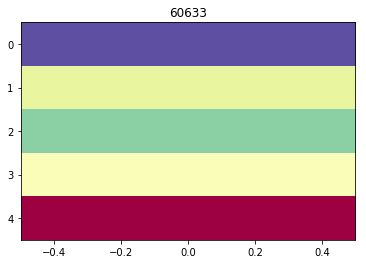

In [260]:
# Grouping data
for zipcode in list(zillow_chicago.columns):
    frequency = 'M' #string
    series = zillow_chicago[zipcode]
    frequency_groups = series.groupby(pd.Grouper(freq =frequency))
        # Plot grouped df
    df_annual = pd.DataFrame()  #creates blank df
    for yr, group in frequency_groups:
        df_annual[yr.year] = group.values.ravel()
        # Heatmaps
    year_matrix = df_annual.T #each row=1 year, each column=1 month
    plt.imshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
    plt.title('{}'.format(zipcode))
    plt.show()

# y-years
# x-time in months

From the rainbow plots above there is no visible seasonality in our data. 

### Rolling Mean

In [22]:
def stationarity_check(TS, column):
    '''Outputs a plot of the Rolling Mean and prints results of the Dickey-Fuller Test
      TS: Time Series, this is the dataframe from which you are pulling your information
      column: This is the column within the TS that you are interested in, e.g. the zipcode or stock ticker'''
    # Calculate rolling statistics
    rolmean = TS[column].rolling(window = 8, center = False).mean()
    rolstd = TS[column].rolling(window = 8, center = False).std()
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column].dropna()) # change the passengers column as required
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS[column], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for {}'.format(column))
    plt.show(block=False)
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


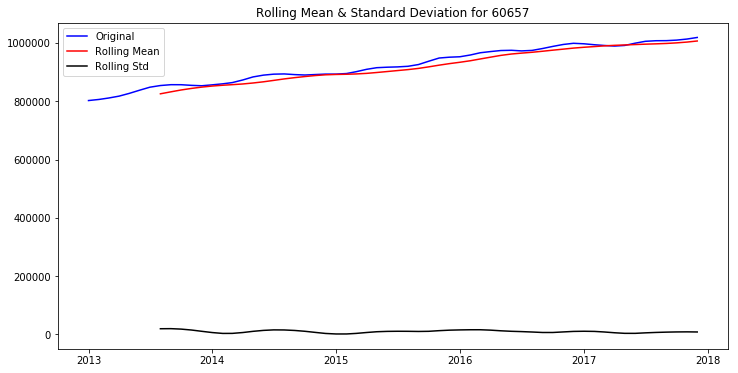

Results of Dickey-Fuller Test:
Test Statistic                 -0.554385
p-value                         0.880960
#Lags Used                      8.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


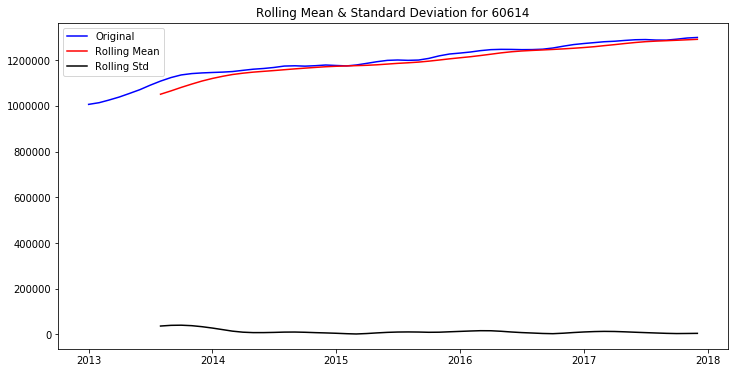

Results of Dickey-Fuller Test:
Test Statistic                 -2.092300
p-value                         0.247622
#Lags Used                      4.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


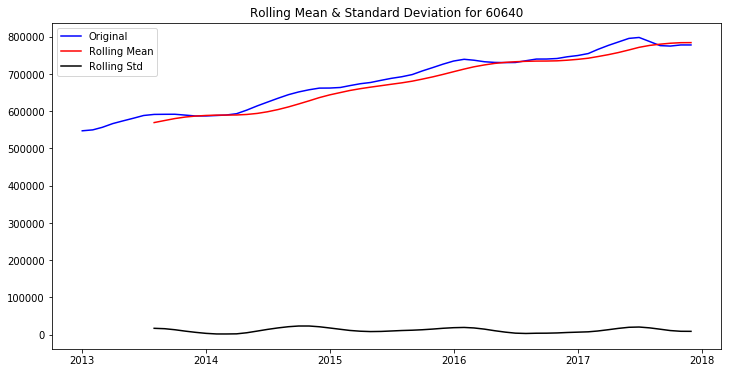

Results of Dickey-Fuller Test:
Test Statistic                 -1.659611
p-value                         0.452033
#Lags Used                      9.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


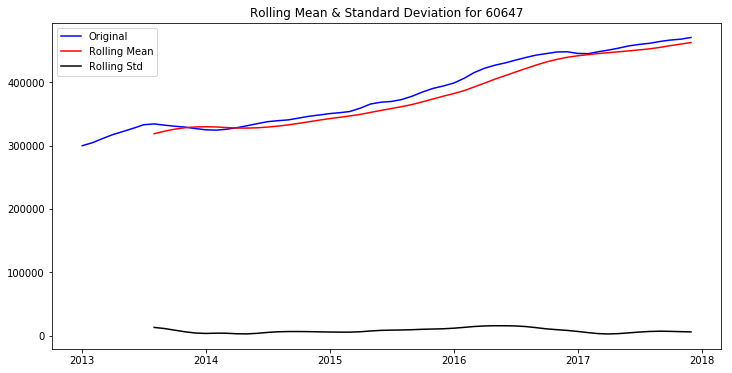

Results of Dickey-Fuller Test:
Test Statistic                  0.747417
p-value                         0.990738
#Lags Used                      6.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


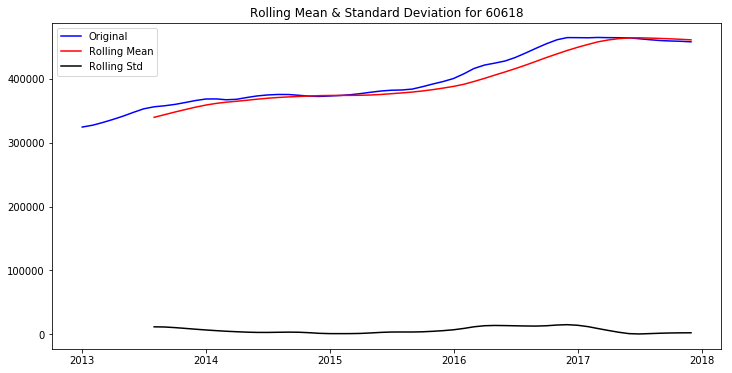

Results of Dickey-Fuller Test:
Test Statistic                 -0.649147
p-value                         0.859486
#Lags Used                      8.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


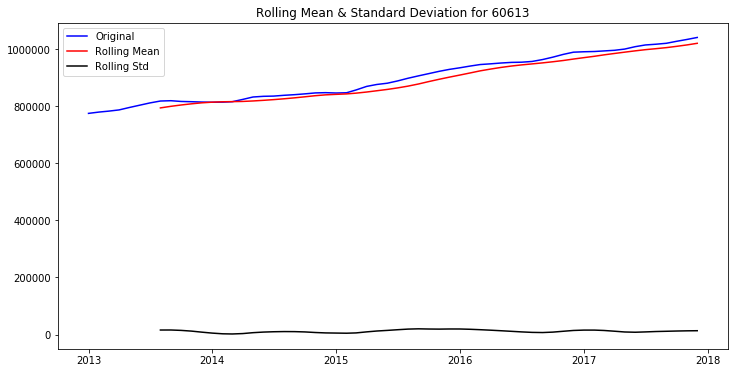

Results of Dickey-Fuller Test:
Test Statistic                  1.037762
p-value                         0.994649
#Lags Used                      5.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


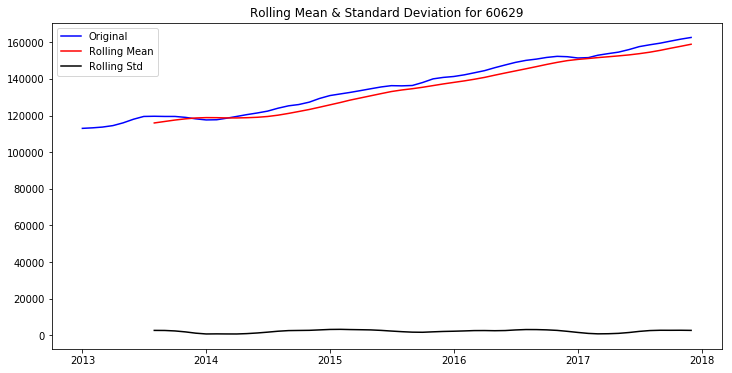

Results of Dickey-Fuller Test:
Test Statistic                  0.868340
p-value                         0.992663
#Lags Used                      4.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


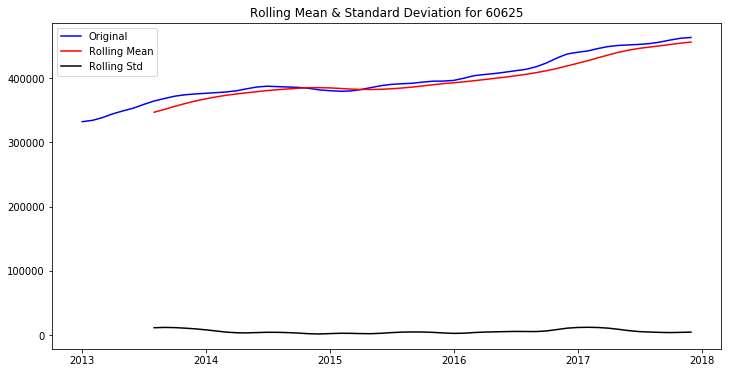

Results of Dickey-Fuller Test:
Test Statistic                 -0.259214
p-value                         0.931085
#Lags Used                      4.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


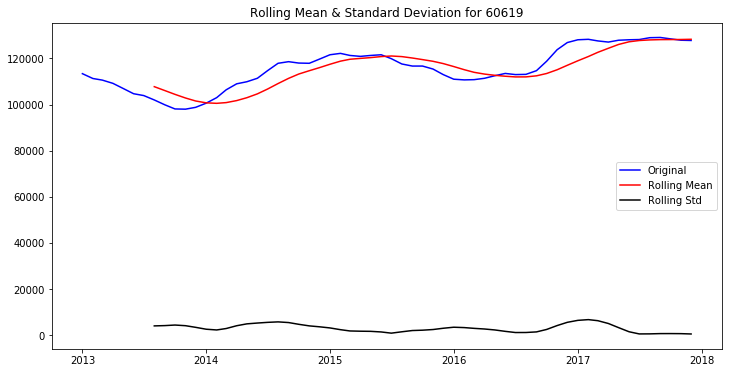

Results of Dickey-Fuller Test:
Test Statistic                 -2.195397
p-value                         0.207920
#Lags Used                      3.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


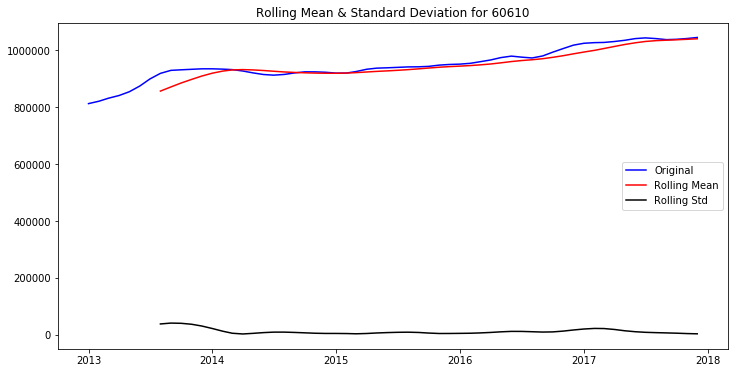

Results of Dickey-Fuller Test:
Test Statistic                  0.914549
p-value                         0.993277
#Lags Used                     11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


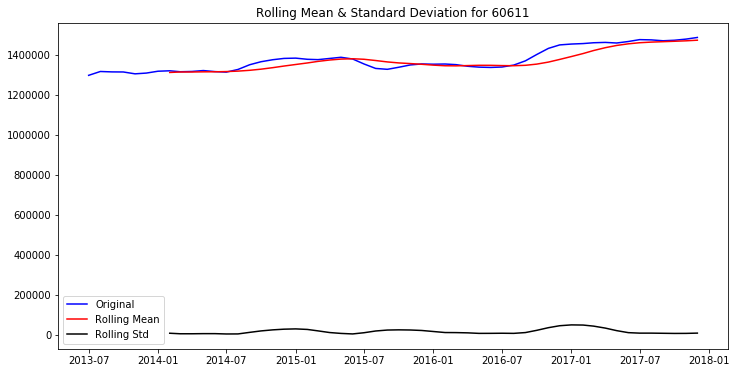

Results of Dickey-Fuller Test:
Test Statistic                 -0.860278
p-value                         0.800772
#Lags Used                      4.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64


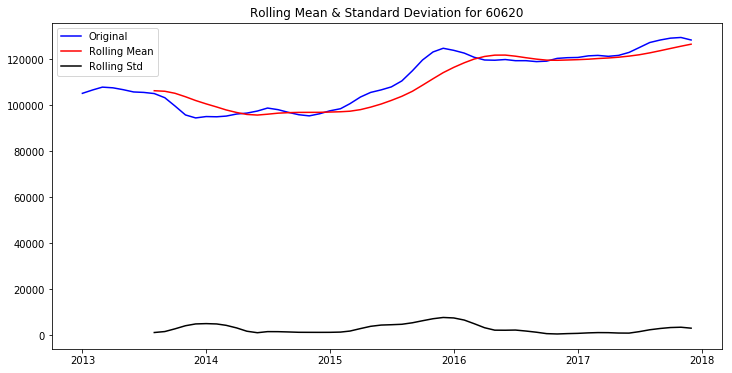

Results of Dickey-Fuller Test:
Test Statistic                 -1.008662
p-value                         0.750092
#Lags Used                      9.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


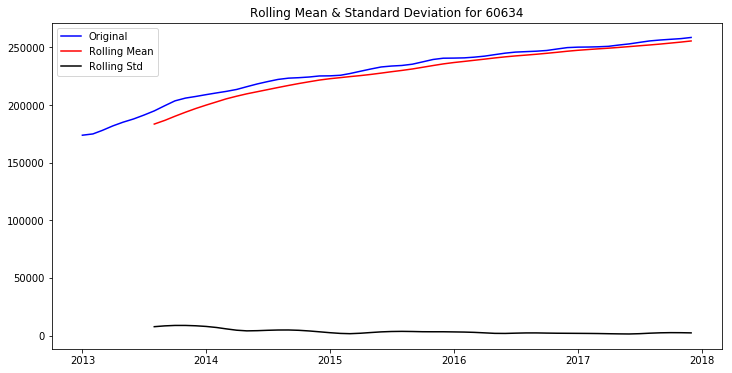

Results of Dickey-Fuller Test:
Test Statistic                 -3.434923
p-value                         0.009824
#Lags Used                      4.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


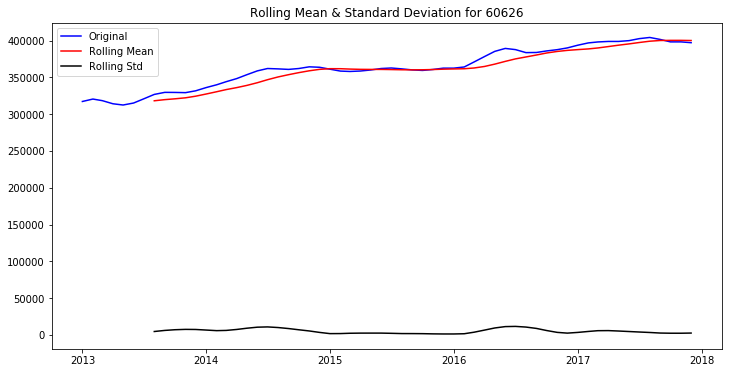

Results of Dickey-Fuller Test:
Test Statistic                 -2.164363
p-value                         0.219433
#Lags Used                      4.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


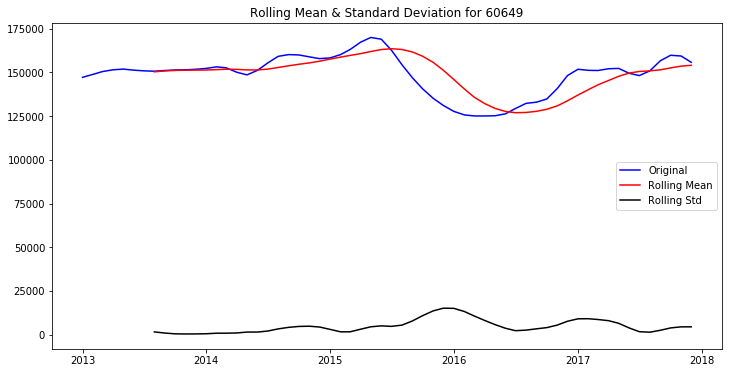

Results of Dickey-Fuller Test:
Test Statistic                 -2.974063
p-value                         0.037389
#Lags Used                      6.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


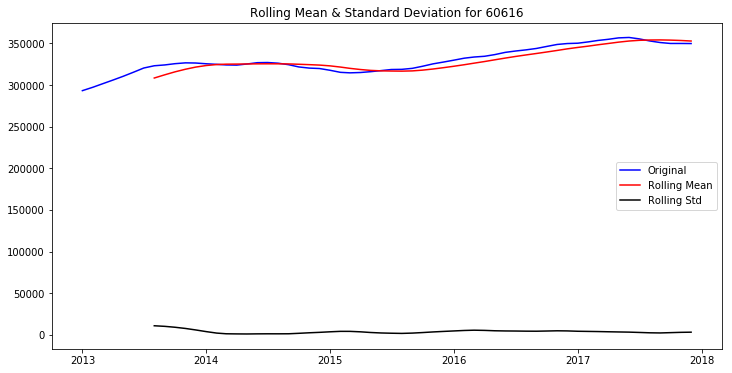

Results of Dickey-Fuller Test:
Test Statistic                 -0.740161
p-value                         0.836071
#Lags Used                      7.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


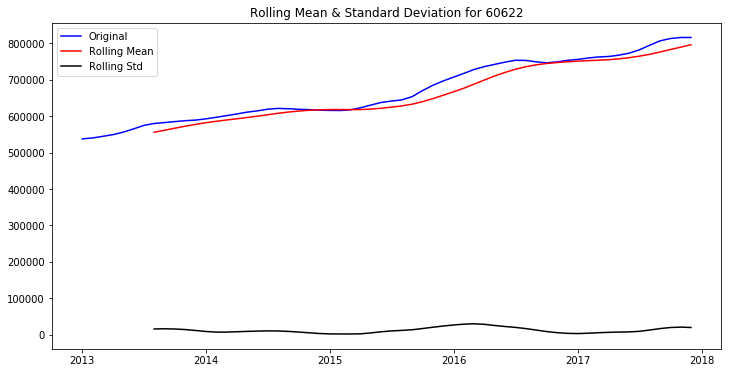

Results of Dickey-Fuller Test:
Test Statistic                  0.341163
p-value                         0.979156
#Lags Used                      9.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


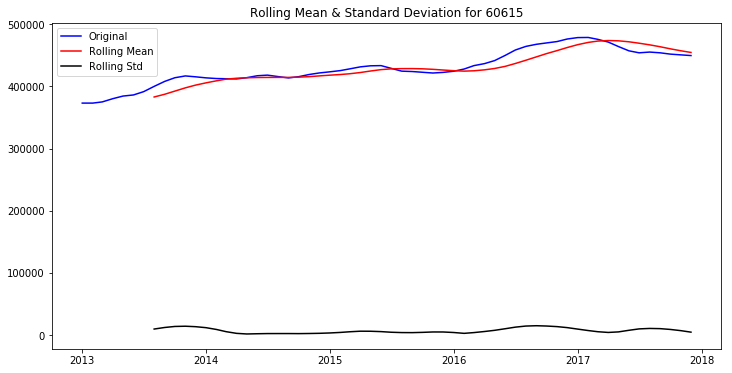

Results of Dickey-Fuller Test:
Test Statistic                 -1.866044
p-value                         0.348200
#Lags Used                      3.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


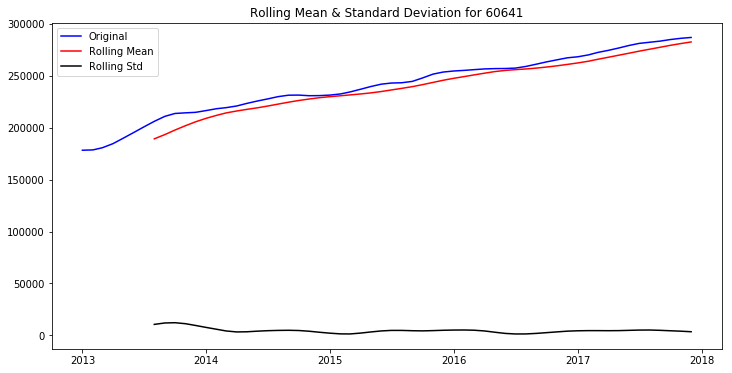

Results of Dickey-Fuller Test:
Test Statistic                 -1.493492
p-value                         0.536728
#Lags Used                      4.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


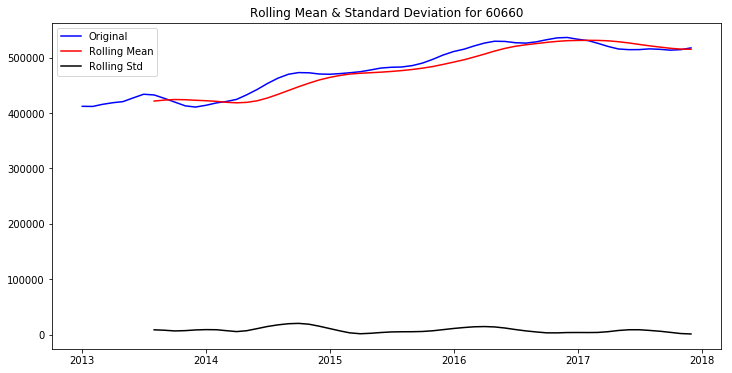

Results of Dickey-Fuller Test:
Test Statistic                 -1.325352
p-value                         0.617495
#Lags Used                      3.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


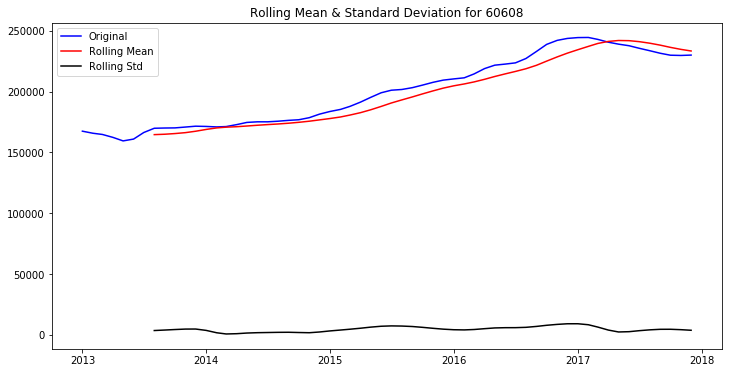

Results of Dickey-Fuller Test:
Test Statistic                 -2.147796
p-value                         0.225735
#Lags Used                      3.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


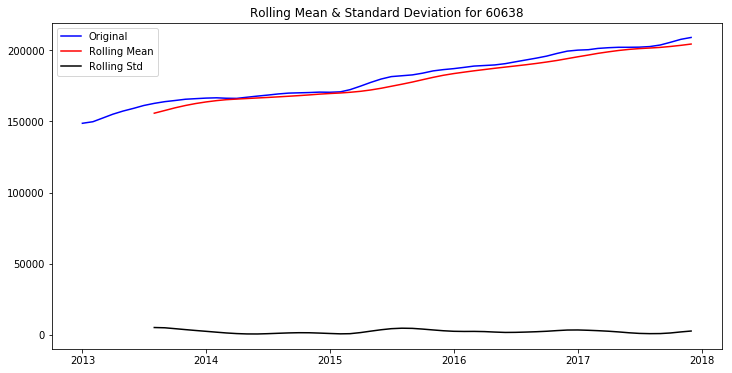

Results of Dickey-Fuller Test:
Test Statistic                  0.382304
p-value                         0.980821
#Lags Used                      7.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


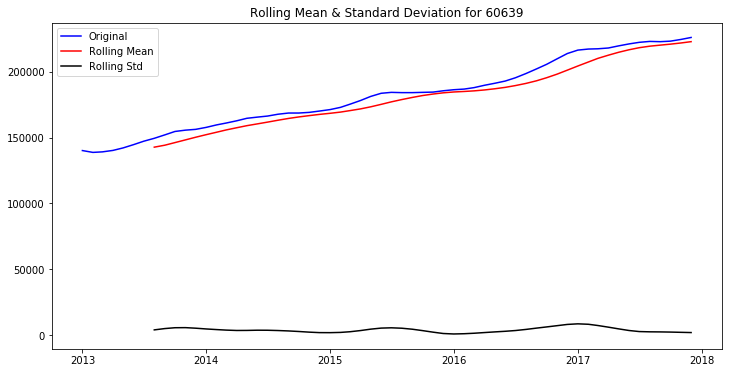

Results of Dickey-Fuller Test:
Test Statistic                  0.455833
p-value                         0.983467
#Lags Used                      7.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


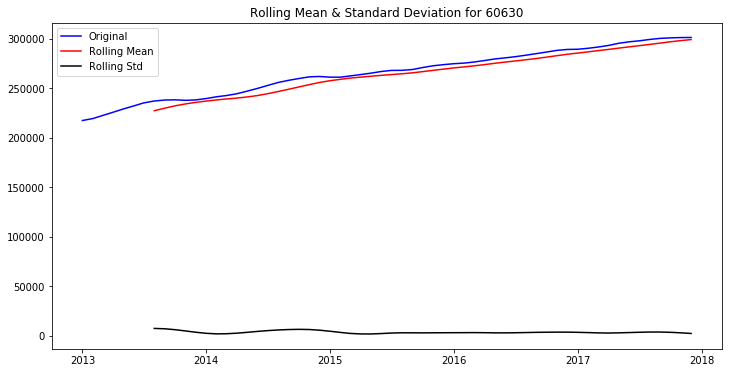

Results of Dickey-Fuller Test:
Test Statistic                 -2.444598
p-value                         0.129543
#Lags Used                      7.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


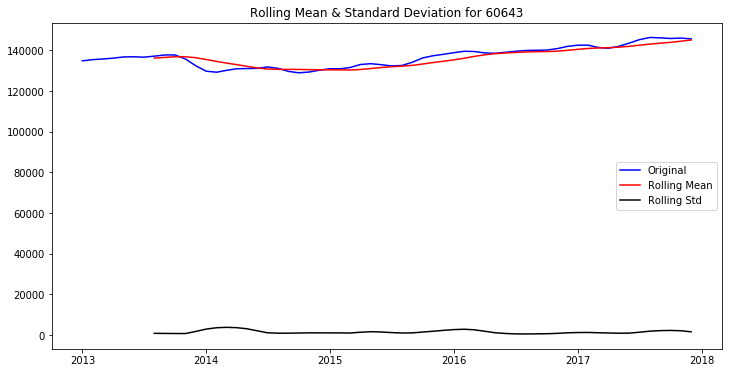

Results of Dickey-Fuller Test:
Test Statistic                 -0.897873
p-value                         0.788672
#Lags Used                      8.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


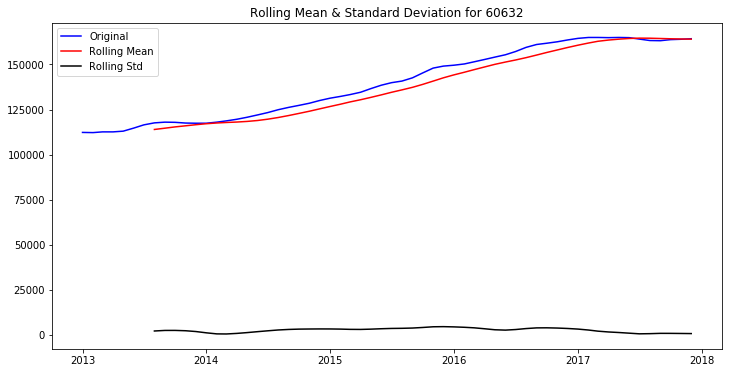

Results of Dickey-Fuller Test:
Test Statistic                 -0.464443
p-value                         0.898771
#Lags Used                      5.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


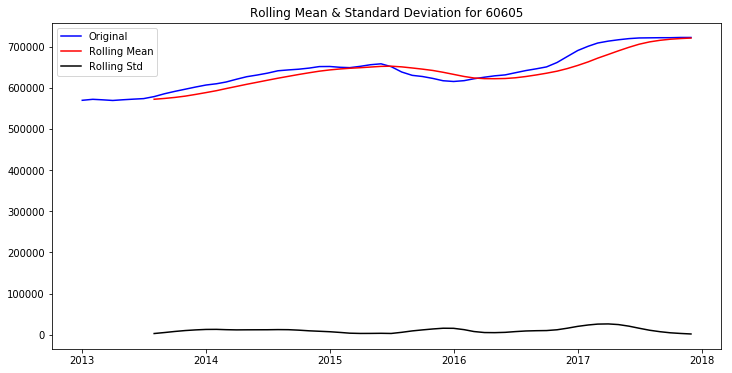

Results of Dickey-Fuller Test:
Test Statistic                 -1.912321
p-value                         0.326287
#Lags Used                      3.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


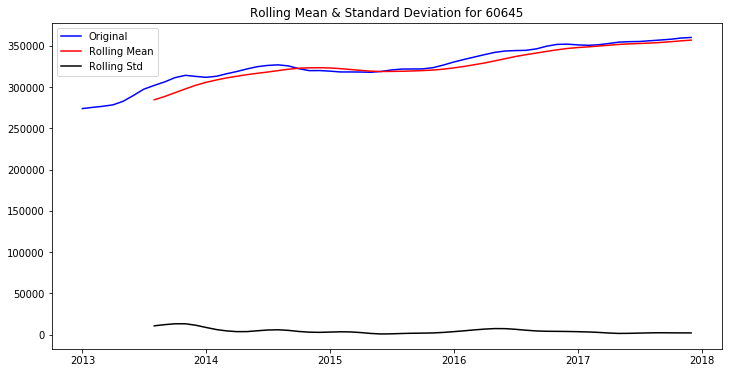

Results of Dickey-Fuller Test:
Test Statistic                 -0.979708
p-value                         0.760593
#Lags Used                      5.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


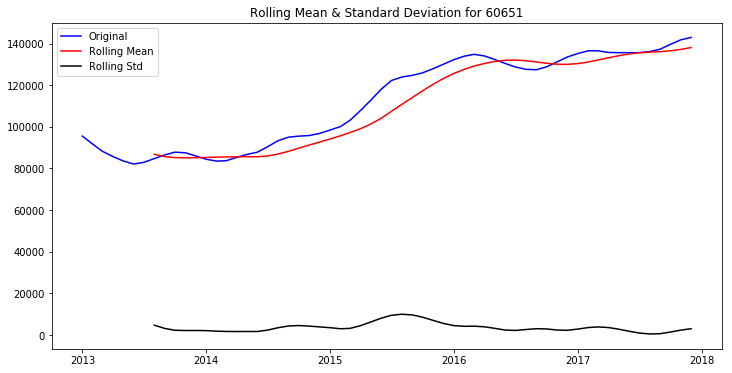

Results of Dickey-Fuller Test:
Test Statistic                 -1.151816
p-value                         0.693973
#Lags Used                      5.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


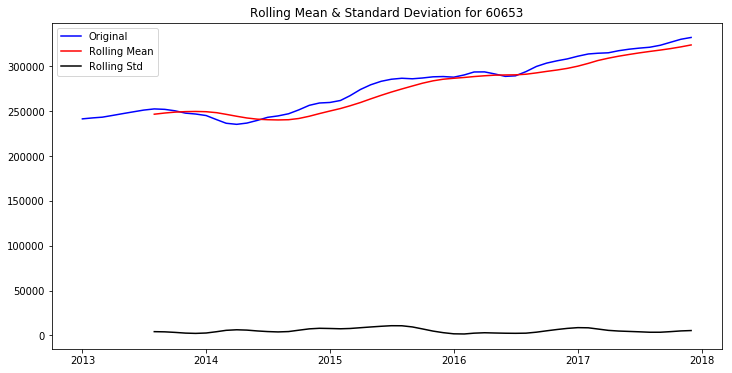

Results of Dickey-Fuller Test:
Test Statistic                  0.086587
p-value                         0.965133
#Lags Used                      3.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


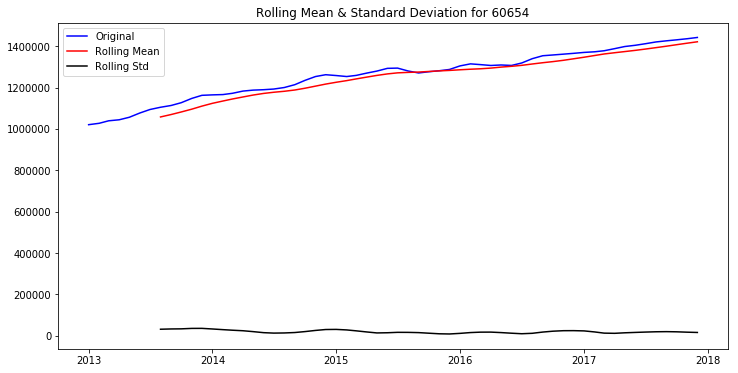

Results of Dickey-Fuller Test:
Test Statistic                 -1.116630
p-value                         0.708395
#Lags Used                      7.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


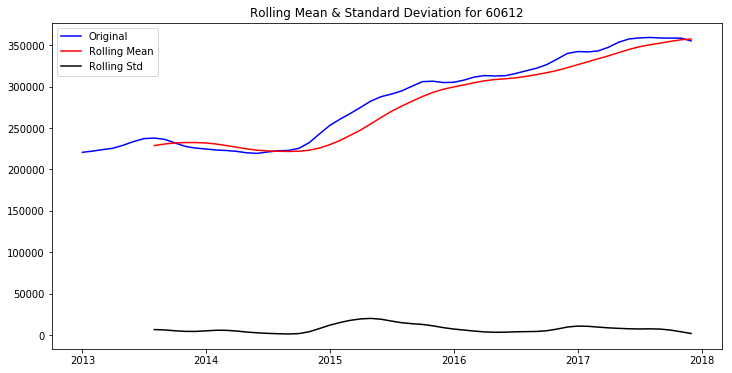

Results of Dickey-Fuller Test:
Test Statistic                 -0.960445
p-value                         0.767416
#Lags Used                      4.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


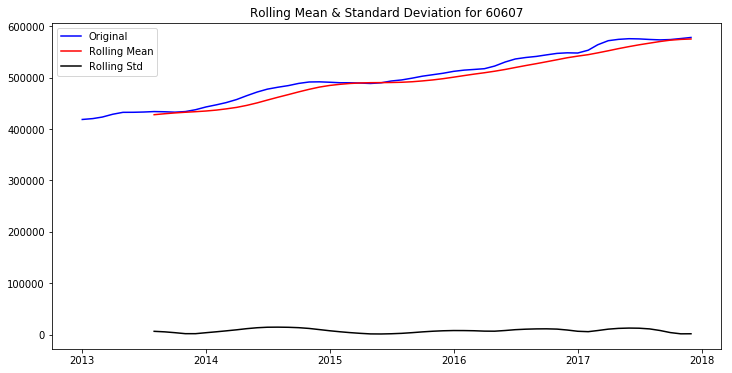

Results of Dickey-Fuller Test:
Test Statistic                 -1.012315
p-value                         0.748746
#Lags Used                      9.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


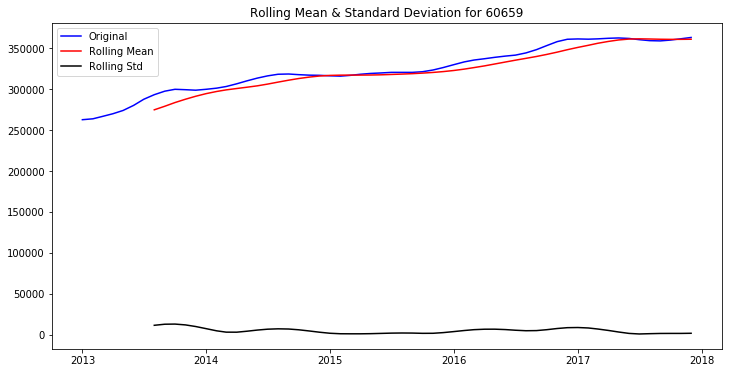

Results of Dickey-Fuller Test:
Test Statistic                 -0.940856
p-value                         0.774221
#Lags Used                      5.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


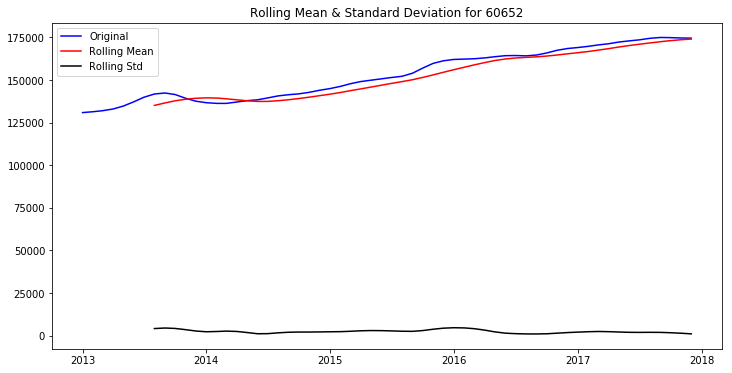

Results of Dickey-Fuller Test:
Test Statistic                 -0.060380
p-value                         0.953245
#Lags Used                      4.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


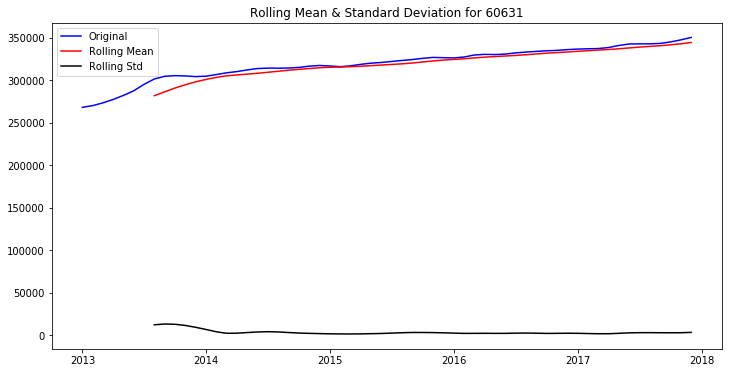

Results of Dickey-Fuller Test:
Test Statistic                  1.563617
p-value                         0.997744
#Lags Used                      9.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


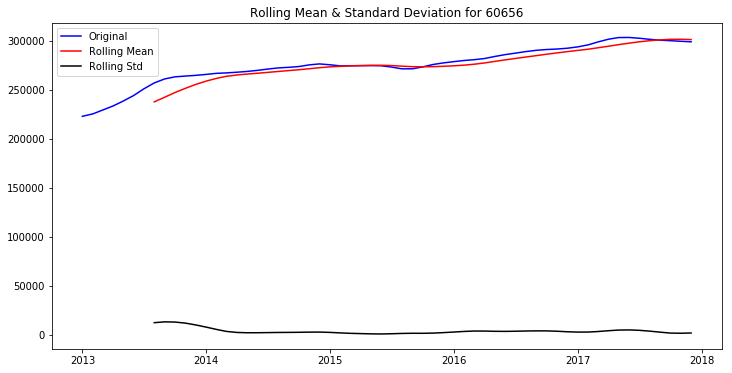

Results of Dickey-Fuller Test:
Test Statistic                 -0.691160
p-value                         0.849026
#Lags Used                      8.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


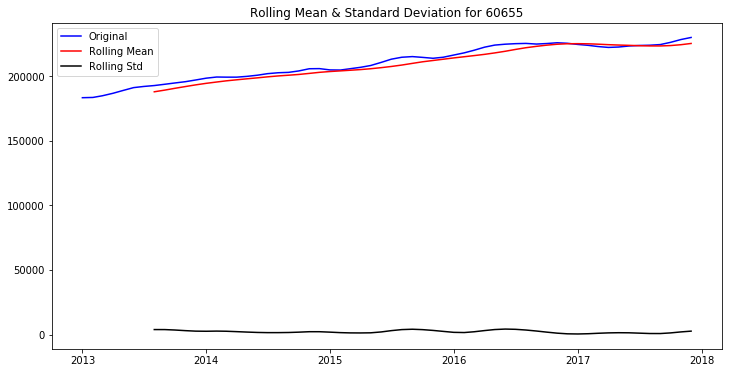

Results of Dickey-Fuller Test:
Test Statistic                 -1.299821
p-value                         0.629254
#Lags Used                      4.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


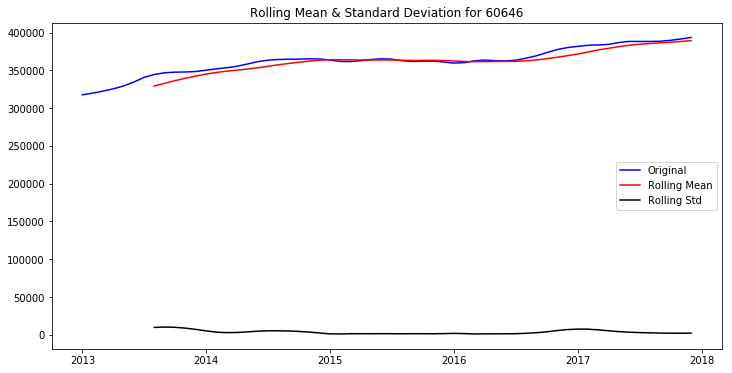

Results of Dickey-Fuller Test:
Test Statistic                 -0.310306
p-value                         0.924032
#Lags Used                      5.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


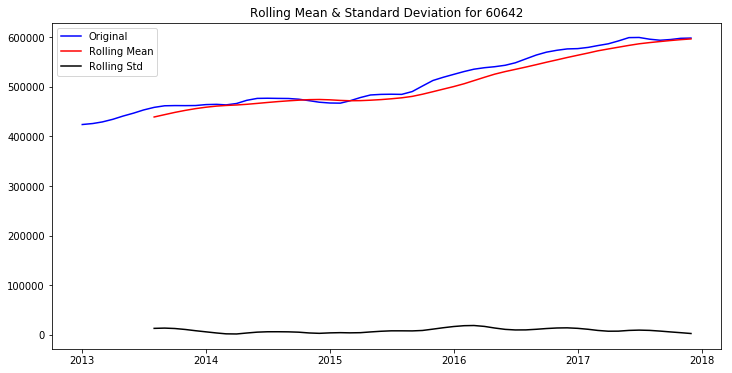

Results of Dickey-Fuller Test:
Test Statistic                 -0.396144
p-value                         0.910741
#Lags Used                      3.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


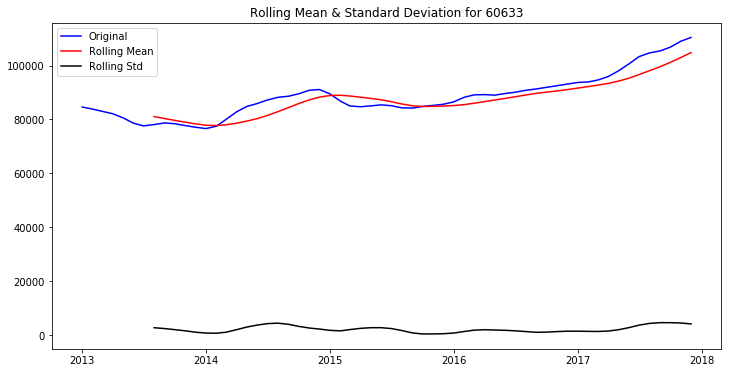

Results of Dickey-Fuller Test:
Test Statistic                  1.715147
p-value                         0.998165
#Lags Used                     11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [23]:
[stationarity_check(zillow_chicago,x) for x in list(zillow_chicago.columns)]

Trend in the mean, variance is fairly close to zero and is constant. 

## Removing trend and seasonality

In [153]:



def detrend(TS, alpha=0.05):
    
    '''Selecting the best method for detrending timeseries based on 
        lowest p-value of the augmented Dickey-Fuller.
        TS: timeseries dataframe
        alpha: alpha value for Dickey-Fuller '''
    
    new_TS = pd.DataFrame()
    
    plist = []
    for column in list(TS.columns):

        p_values = []
        # zipcode 60611 has NaN, so we can't detrend
        if column==60611:
            pass
        else:

            decomposition=seasonal_decompose(TS[column].dropna())
            residuals = decomposition.resid
            dftest = adfuller(residuals.dropna(),maxlag=4)
            dfoutput1 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput1['Critical Values (%s)' %key] = value
            p_values.append(dfoutput1[1])


            data_diff1 = TS[column].diff(periods=1)
            dftest = adfuller(data_diff1.dropna(),maxlag=4)
            dfoutput2 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput2['Critical Values (%s)' %key] = value
            p_values.append(dfoutput2[1])

            data_diff2 = TS[column].apply(lambda x: np.log(x)) - TS[column].apply(lambda x: np.log(x)).shift(1)
            dftest = adfuller(data_diff2.dropna(),maxlag=4)
            dfoutput3 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput3['Critical Values (%s)' %key] = value
            p_values.append(dfoutput3[1])


            temp_diff = TS[column].apply(lambda x: np.log(x)) - TS[column].apply(lambda x: np.log(x)).shift(1)
            data_diff3 = temp_diff - temp_diff.shift(12)  
            dftest = adfuller(data_diff3.dropna(),maxlag=4)
            dfoutput4 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput4['Critical Values (%s)' %key] = value
            p_values.append(dfoutput4[1])

            if np.argmin(p_values)==0:
                residuals.plot(figsize=(20,6))
                plt.title('{} Seasonal Decomposition'.format(column))
                plt.show();
                print(dfoutput1)
                new_TS[column]=residuals

            elif np.argmin(p_values)==1:
                data_diff1.plot(figsize=(20,6))
                plt.title('{} First Difference'.format(column))
                plt.show();
                print(dfoutput2)
                new_TS[column]=data_diff1

            elif np.argmin(p_values)==2:
                data_diff2.plot(figsize=(20,6))
                plt.title('{} Log First Difference'.format(column))
                plt.show();
                print(dfoutput3)
                new_TS[column]=data_diff2

            elif np.argmin(p_values)==3:
                data_diff3.plot(figsize=(20,6))
                plt.title('{} Log Seasonal First Difference'.format(column))
                plt.show();
                print(dfoutput4)
                new_TS[column]=data_diff3

            plist.append(min(p_values))
    print('\n','The p-value above {}:'.format(alpha),(np.array(plist)>alpha).sum())
    return new_TS
  
    

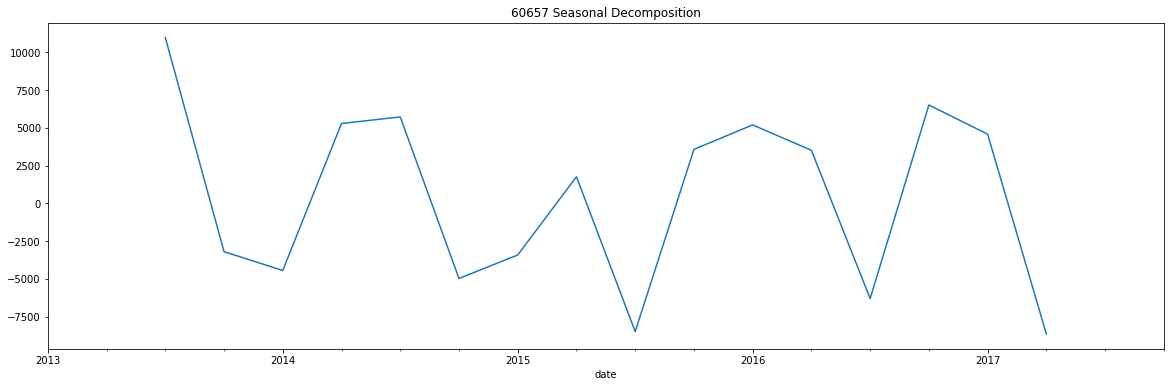

Test Statistic                 -5.086824
p-value                         0.000015
#Lags Used                      1.000000
Number of Observations Used    14.000000
Critical Values (1%)           -4.012034
Critical Values (5%)           -3.104184
Critical Values (10%)          -2.690987
dtype: float64


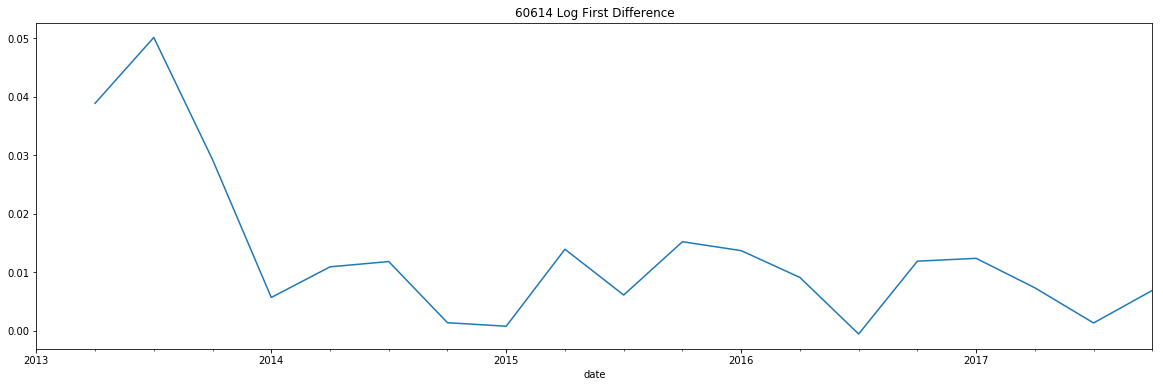

Test Statistic                 -5.268042
p-value                         0.000006
#Lags Used                      1.000000
Number of Observations Used    17.000000
Critical Values (1%)           -3.889266
Critical Values (5%)           -3.054358
Critical Values (10%)          -2.666984
dtype: float64


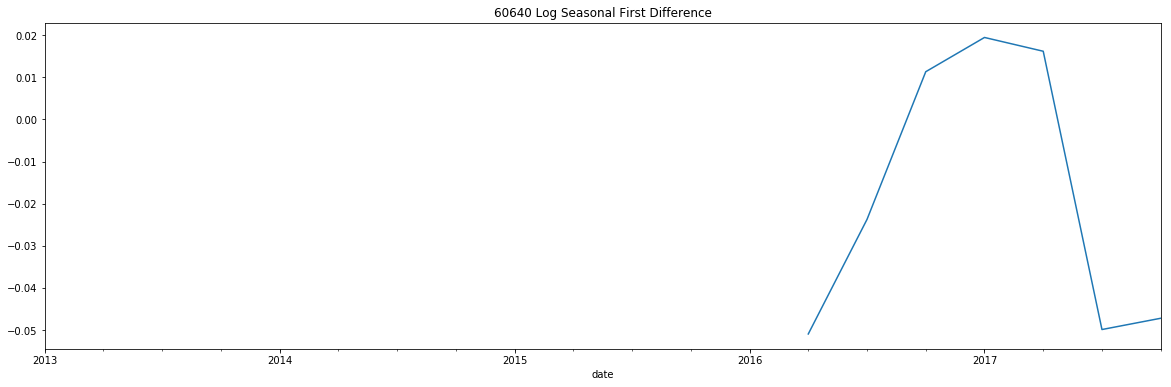

Test Statistic                -1.378395
p-value                        0.592589
#Lags Used                     0.000000
Number of Observations Used    6.000000
Critical Values (1%)          -5.354256
Critical Values (5%)          -3.646238
Critical Values (10%)         -2.901198
dtype: float64


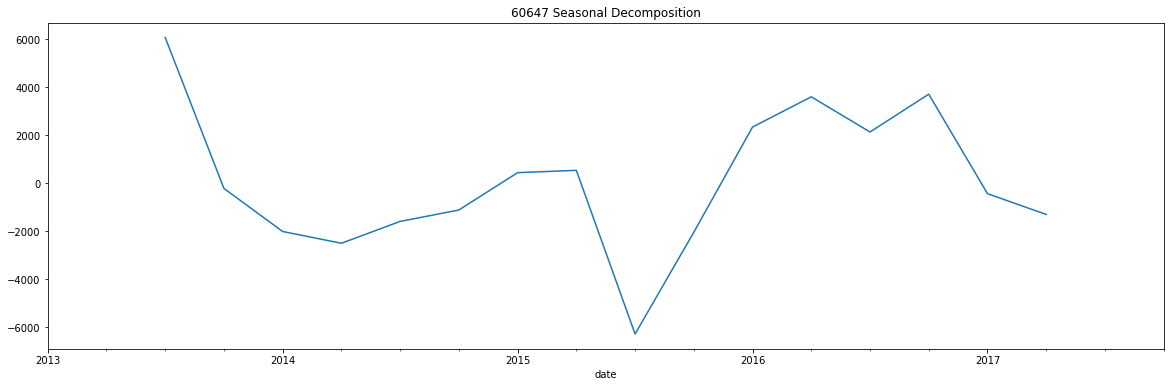

Test Statistic                 -3.198701
p-value                         0.020060
#Lags Used                      0.000000
Number of Observations Used    15.000000
Critical Values (1%)           -3.964443
Critical Values (5%)           -3.084908
Critical Values (10%)          -2.681814
dtype: float64


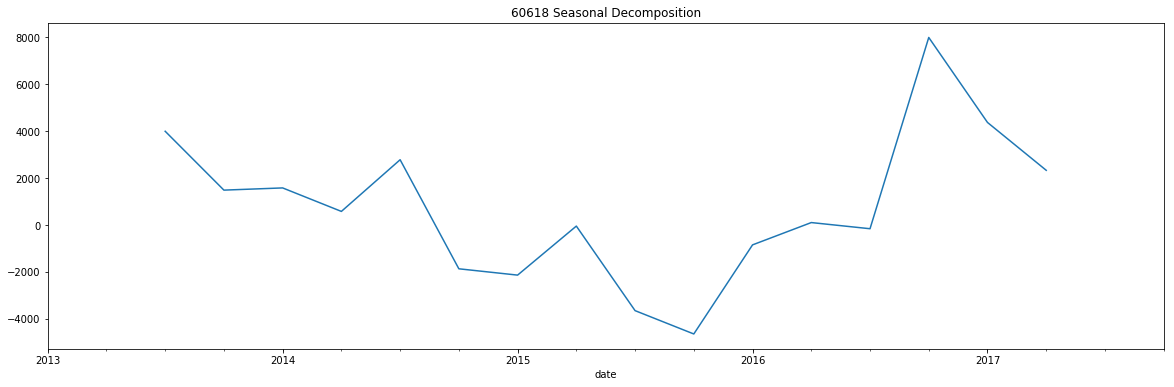

Test Statistic                 -3.887234
p-value                         0.002131
#Lags Used                      4.000000
Number of Observations Used    11.000000
Critical Values (1%)           -4.223238
Critical Values (5%)           -3.189369
Critical Values (10%)          -2.729839
dtype: float64


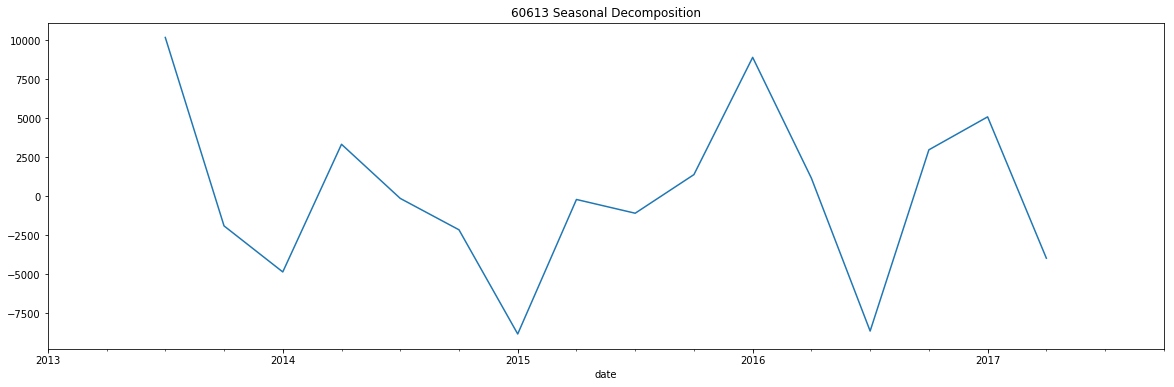

Test Statistic                 -4.323888
p-value                         0.000404
#Lags Used                      1.000000
Number of Observations Used    14.000000
Critical Values (1%)           -4.012034
Critical Values (5%)           -3.104184
Critical Values (10%)          -2.690987
dtype: float64


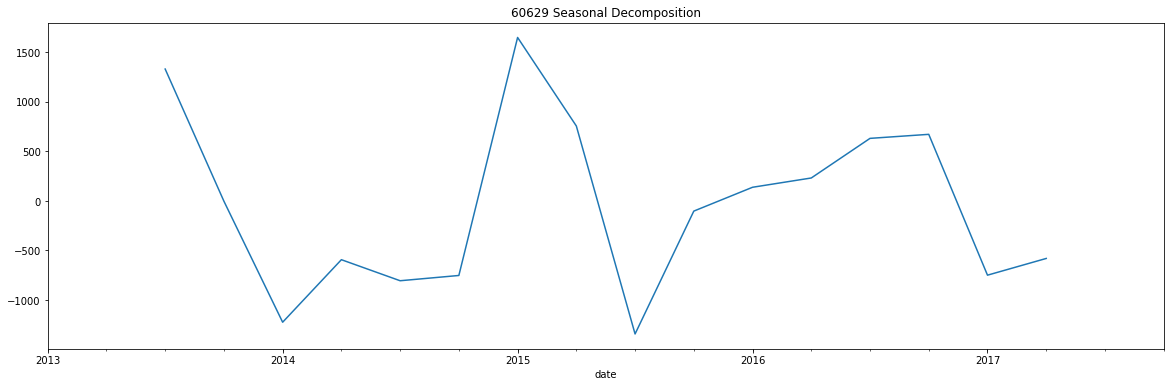

Test Statistic                 -3.713759
p-value                         0.003924
#Lags Used                      3.000000
Number of Observations Used    12.000000
Critical Values (1%)           -4.137829
Critical Values (5%)           -3.154972
Critical Values (10%)          -2.714477
dtype: float64


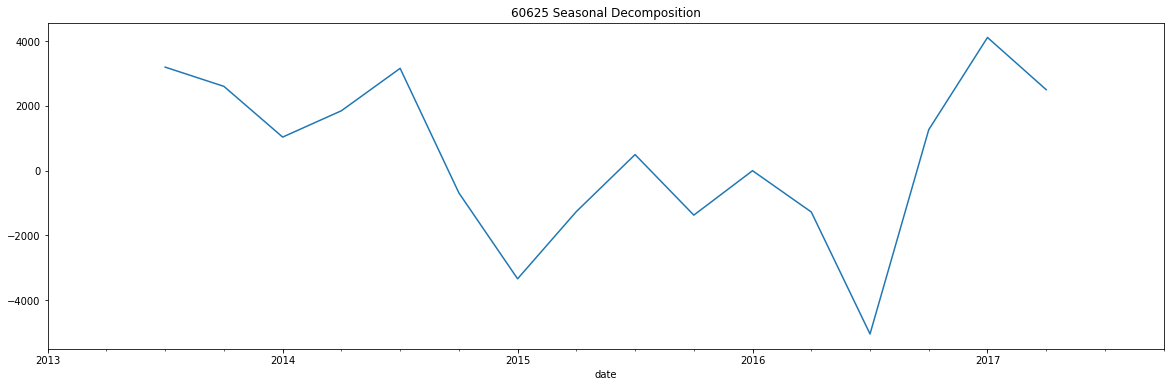

Test Statistic                 -2.826071
p-value                         0.054645
#Lags Used                      1.000000
Number of Observations Used    14.000000
Critical Values (1%)           -4.012034
Critical Values (5%)           -3.104184
Critical Values (10%)          -2.690987
dtype: float64


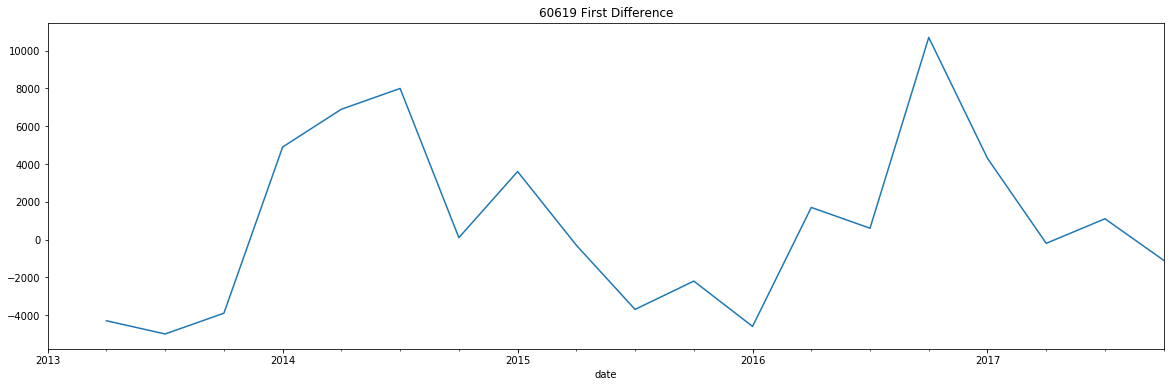

Test Statistic                 -2.674034
p-value                         0.078640
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Values (1%)           -3.859073
Critical Values (5%)           -3.042046
Critical Values (10%)          -2.660906
dtype: float64


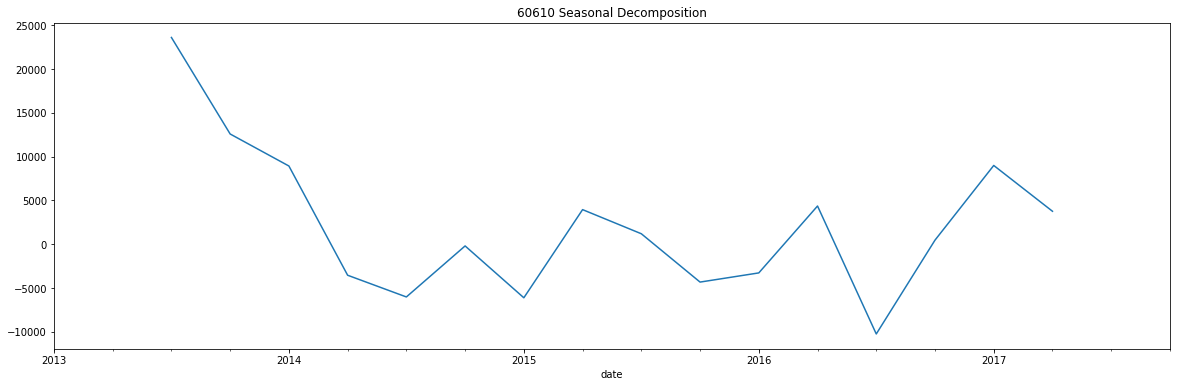

Test Statistic                 -3.687805
p-value                         0.004288
#Lags Used                      0.000000
Number of Observations Used    15.000000
Critical Values (1%)           -3.964443
Critical Values (5%)           -3.084908
Critical Values (10%)          -2.681814
dtype: float64


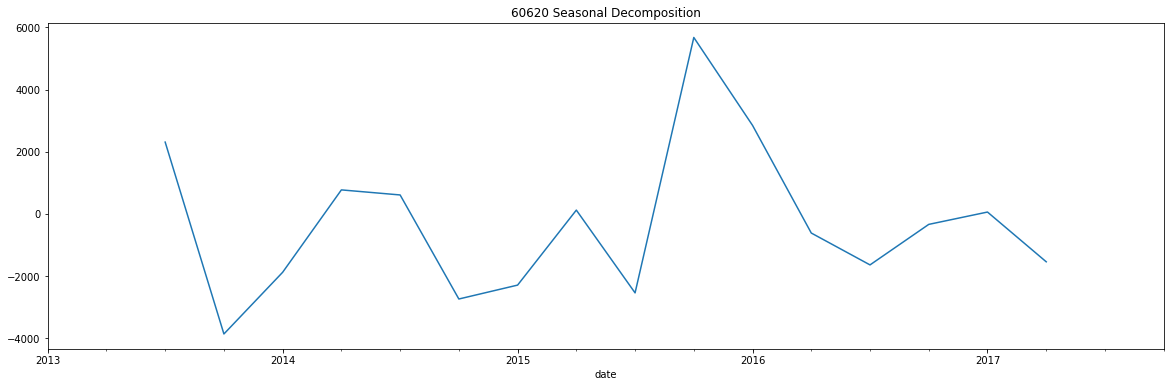

Test Statistic                 -3.685097
p-value                         0.004328
#Lags Used                      0.000000
Number of Observations Used    15.000000
Critical Values (1%)           -3.964443
Critical Values (5%)           -3.084908
Critical Values (10%)          -2.681814
dtype: float64


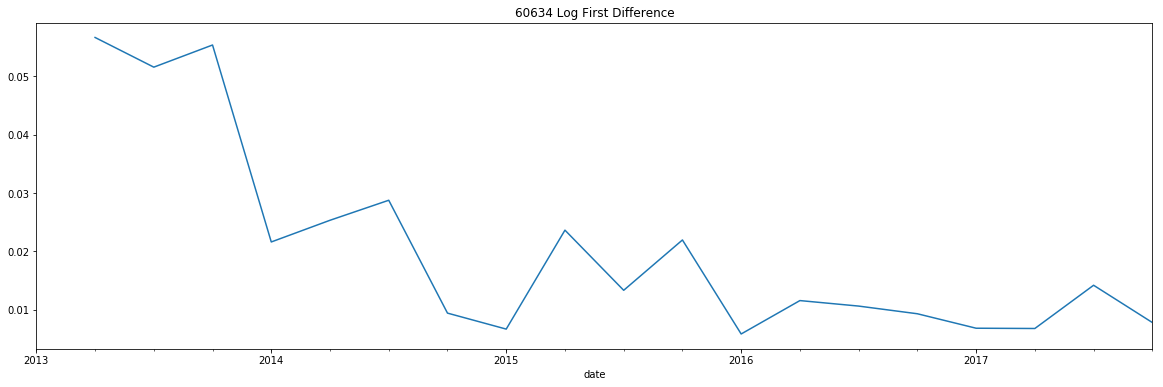

Test Statistic                -5.675116e+00
p-value                        8.740844e-07
#Lags Used                     2.000000e+00
Number of Observations Used    1.600000e+01
Critical Values (1%)          -3.924019e+00
Critical Values (5%)          -3.068498e+00
Critical Values (10%)         -2.673893e+00
dtype: float64


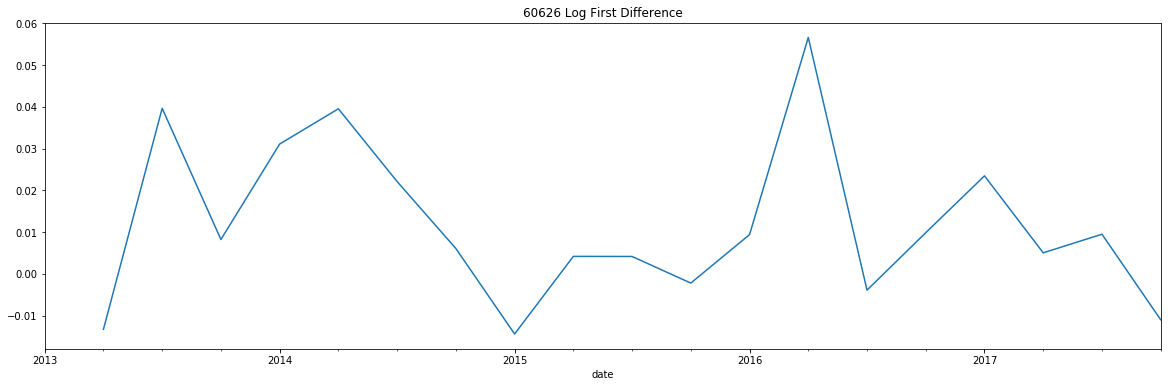

Test Statistic                 -4.313424
p-value                         0.000421
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Values (1%)           -3.859073
Critical Values (5%)           -3.042046
Critical Values (10%)          -2.660906
dtype: float64


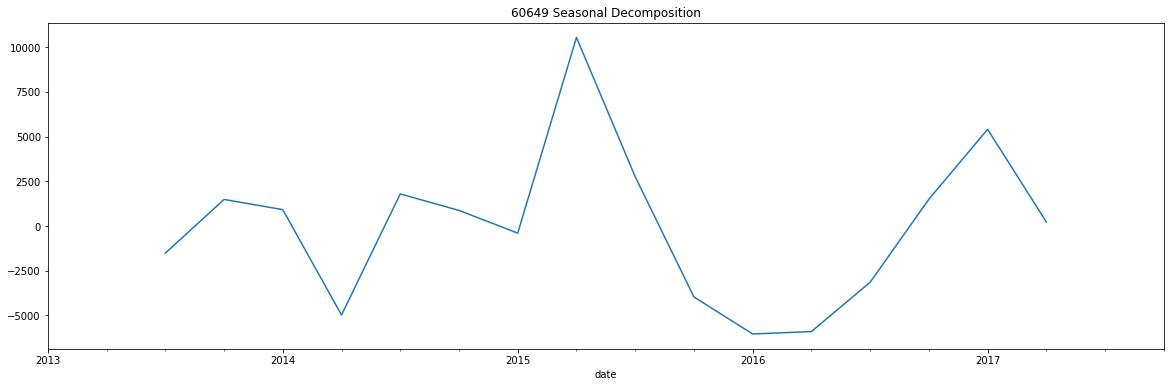

Test Statistic                 -3.405342
p-value                         0.010778
#Lags Used                      3.000000
Number of Observations Used    12.000000
Critical Values (1%)           -4.137829
Critical Values (5%)           -3.154972
Critical Values (10%)          -2.714477
dtype: float64


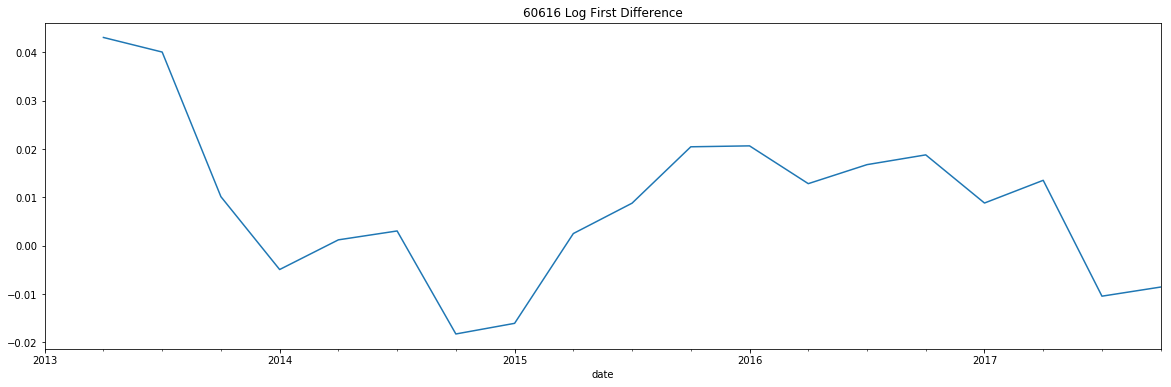

Test Statistic                 -2.423192
p-value                         0.135297
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Values (1%)           -3.859073
Critical Values (5%)           -3.042046
Critical Values (10%)          -2.660906
dtype: float64


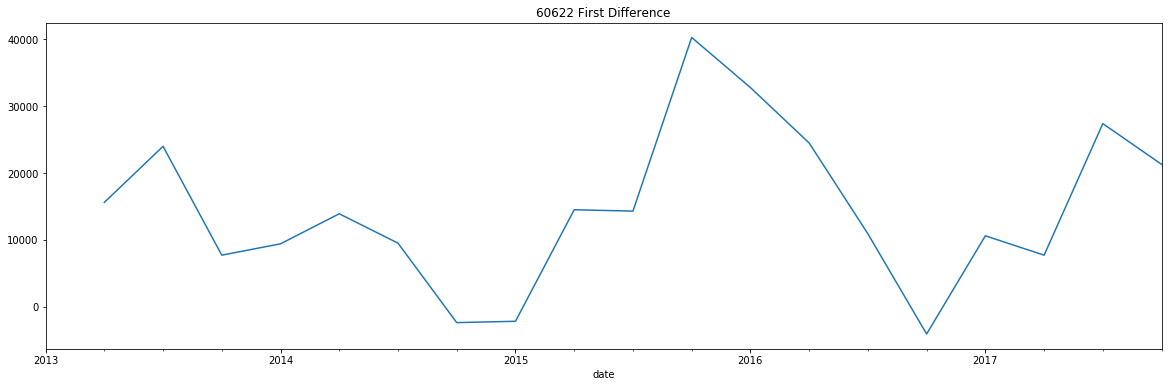

Test Statistic                 -3.300728
p-value                         0.014846
#Lags Used                      2.000000
Number of Observations Used    16.000000
Critical Values (1%)           -3.924019
Critical Values (5%)           -3.068498
Critical Values (10%)          -2.673893
dtype: float64


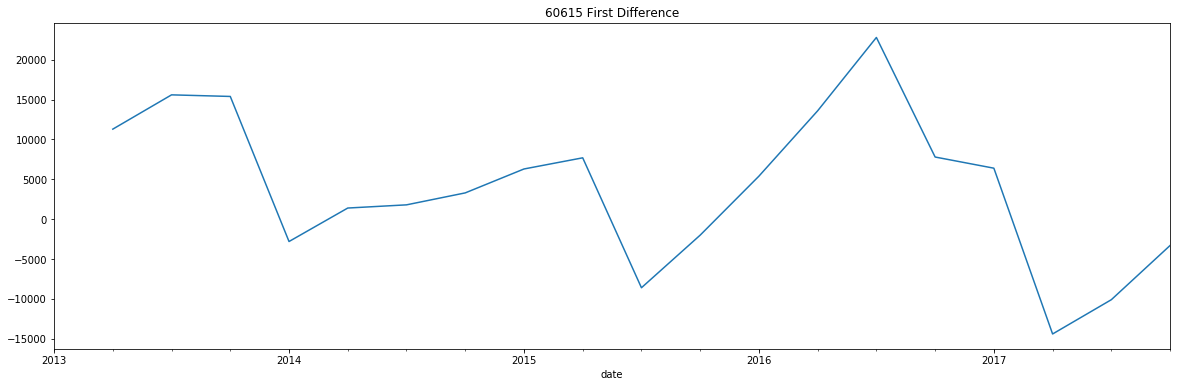

Test Statistic                 -4.022835
p-value                         0.001296
#Lags Used                      2.000000
Number of Observations Used    16.000000
Critical Values (1%)           -3.924019
Critical Values (5%)           -3.068498
Critical Values (10%)          -2.673893
dtype: float64


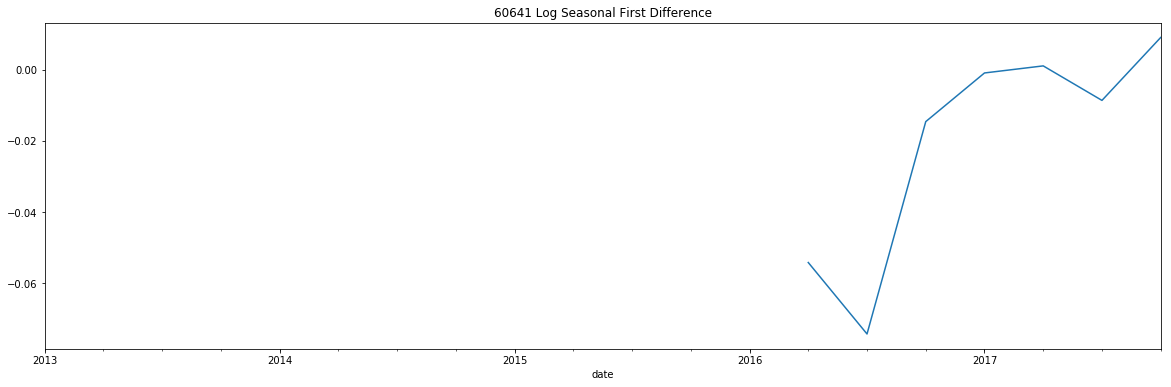

Test Statistic                -4.695956
p-value                        0.000086
#Lags Used                     1.000000
Number of Observations Used    5.000000
Critical Values (1%)          -6.045114
Critical Values (5%)          -3.929280
Critical Values (10%)         -2.986810
dtype: float64


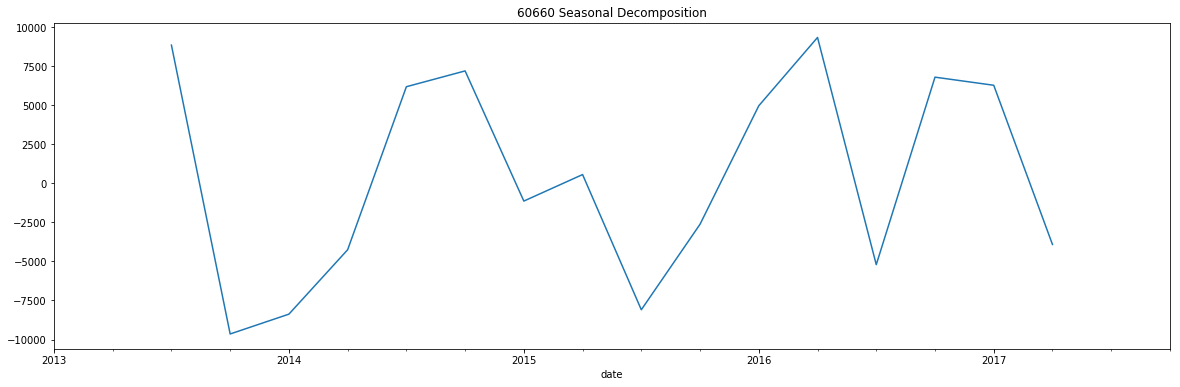

Test Statistic                 -3.622640
p-value                         0.005343
#Lags Used                      0.000000
Number of Observations Used    15.000000
Critical Values (1%)           -3.964443
Critical Values (5%)           -3.084908
Critical Values (10%)          -2.681814
dtype: float64


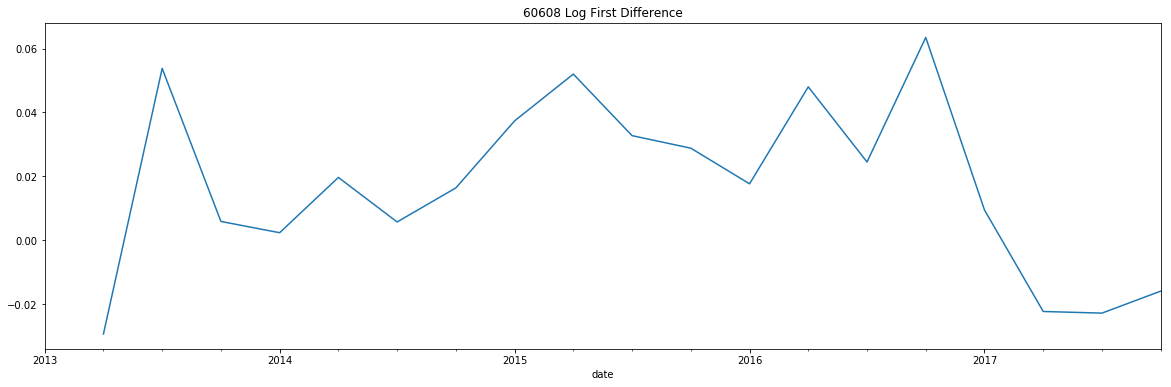

Test Statistic                 -3.351900
p-value                         0.012712
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Values (1%)           -3.859073
Critical Values (5%)           -3.042046
Critical Values (10%)          -2.660906
dtype: float64


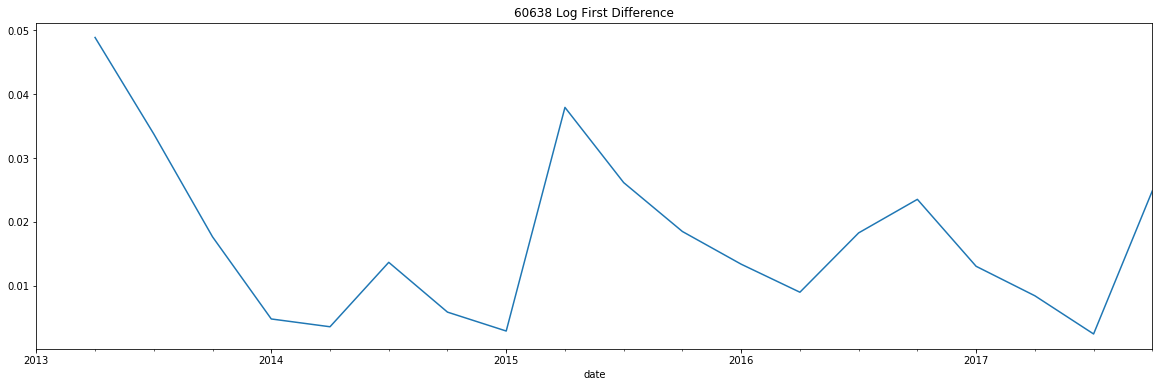

Test Statistic                 -3.706086
p-value                         0.004028
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Values (1%)           -3.859073
Critical Values (5%)           -3.042046
Critical Values (10%)          -2.660906
dtype: float64


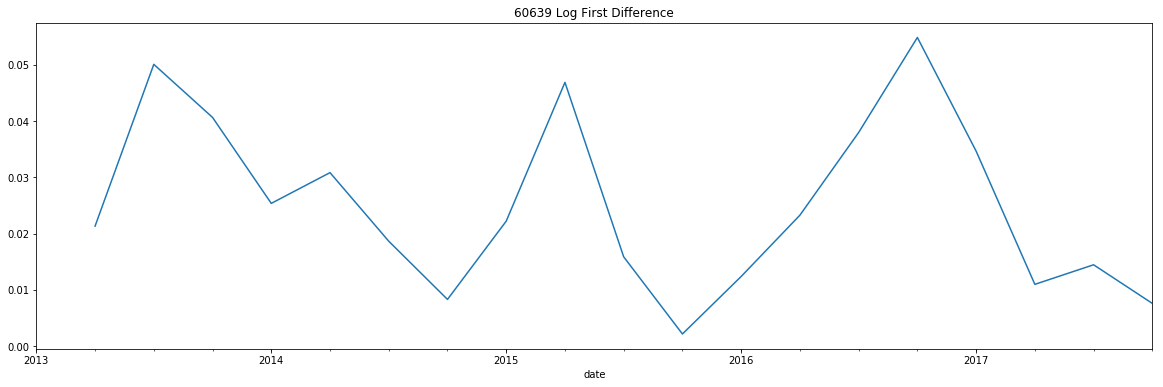

Test Statistic                 -3.496521
p-value                         0.008077
#Lags Used                      3.000000
Number of Observations Used    15.000000
Critical Values (1%)           -3.964443
Critical Values (5%)           -3.084908
Critical Values (10%)          -2.681814
dtype: float64


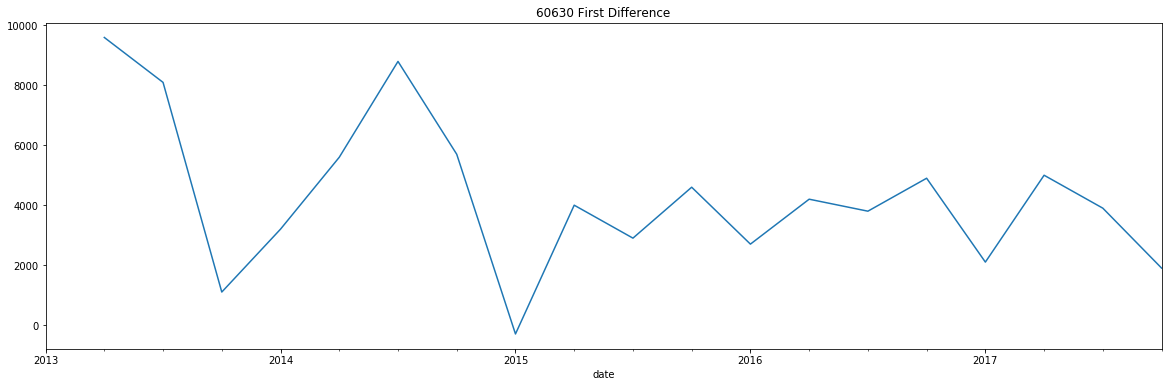

Test Statistic                 -3.937622
p-value                         0.001775
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Values (1%)           -3.859073
Critical Values (5%)           -3.042046
Critical Values (10%)          -2.660906
dtype: float64


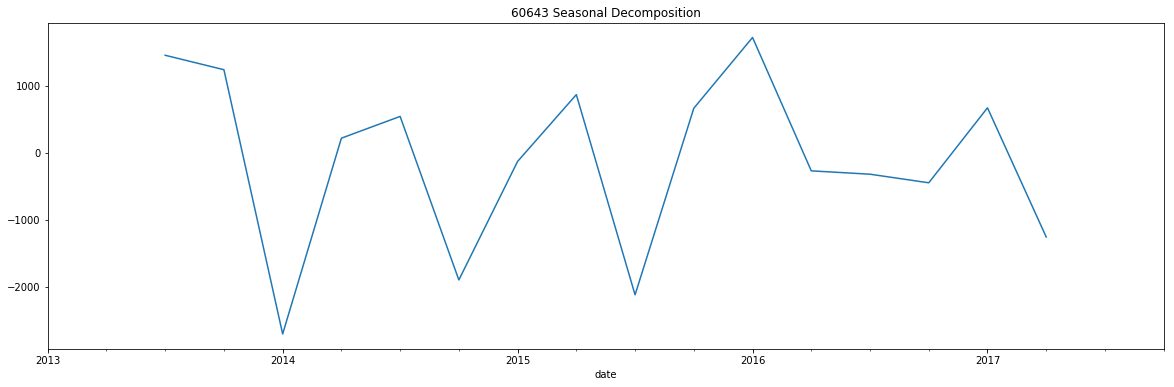

Test Statistic                -6.616718e+00
p-value                        6.180889e-09
#Lags Used                     1.000000e+00
Number of Observations Used    1.400000e+01
Critical Values (1%)          -4.012034e+00
Critical Values (5%)          -3.104184e+00
Critical Values (10%)         -2.690987e+00
dtype: float64


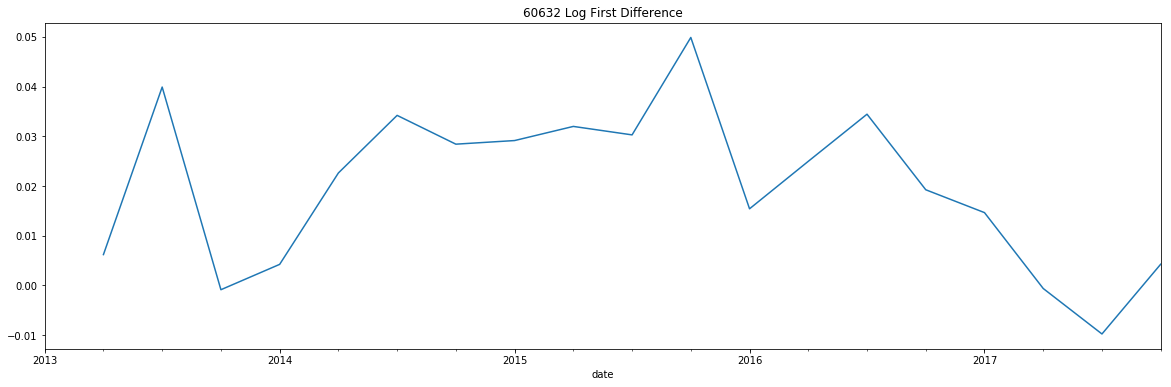

Test Statistic                 -2.802235
p-value                         0.057955
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Values (1%)           -3.859073
Critical Values (5%)           -3.042046
Critical Values (10%)          -2.660906
dtype: float64


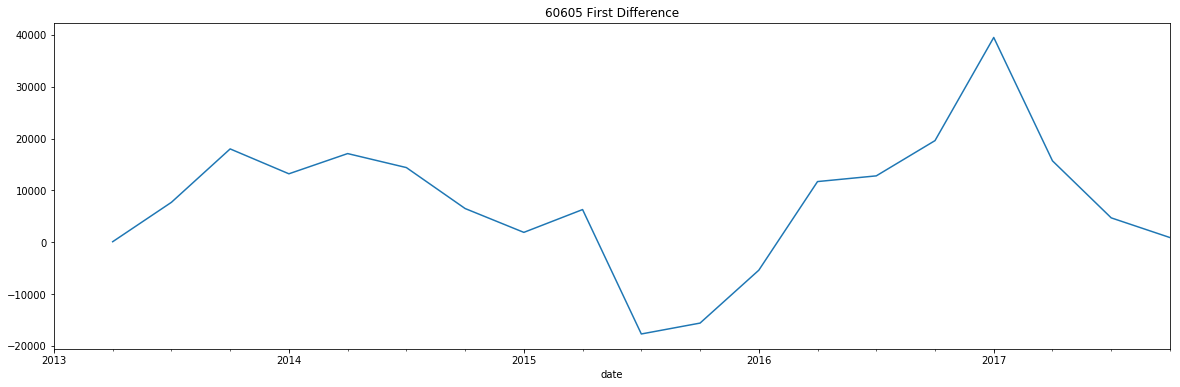

Test Statistic                 -4.007195
p-value                         0.001373
#Lags Used                      4.000000
Number of Observations Used    14.000000
Critical Values (1%)           -4.012034
Critical Values (5%)           -3.104184
Critical Values (10%)          -2.690987
dtype: float64


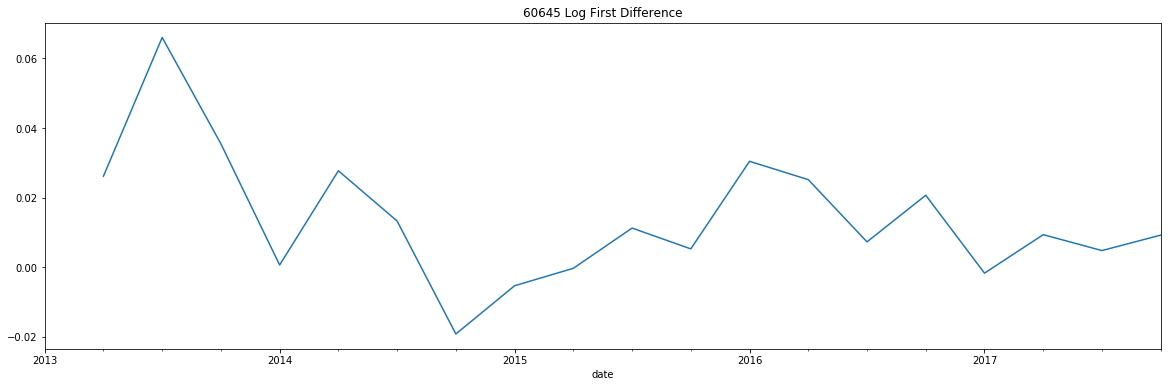

Test Statistic                 -3.567452
p-value                         0.006415
#Lags Used                      4.000000
Number of Observations Used    14.000000
Critical Values (1%)           -4.012034
Critical Values (5%)           -3.104184
Critical Values (10%)          -2.690987
dtype: float64


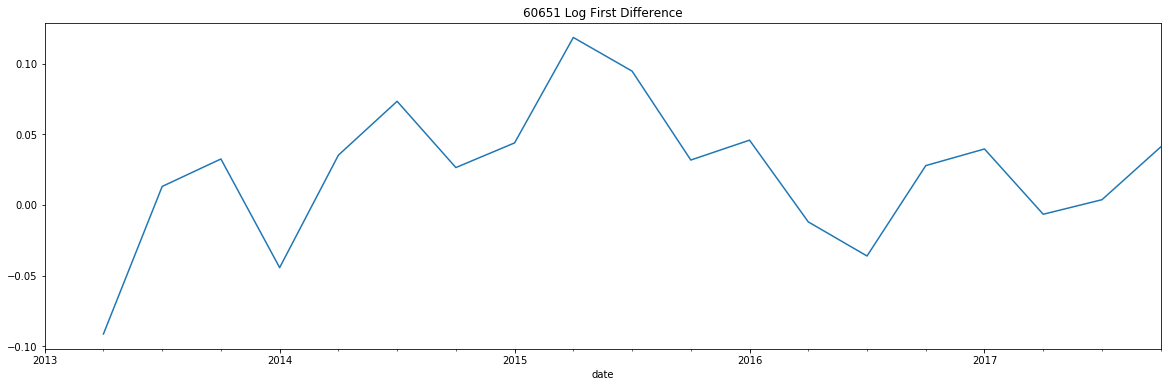

Test Statistic                 -2.702289
p-value                         0.073643
#Lags Used                      3.000000
Number of Observations Used    15.000000
Critical Values (1%)           -3.964443
Critical Values (5%)           -3.084908
Critical Values (10%)          -2.681814
dtype: float64


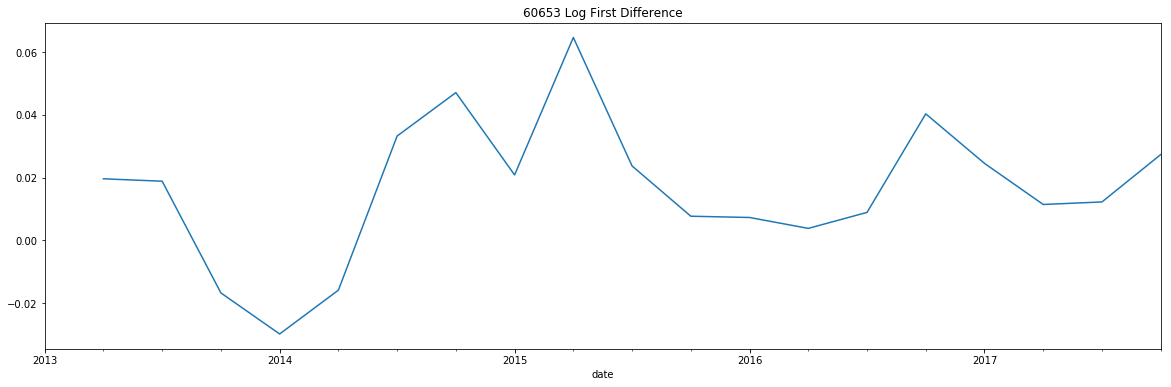

Test Statistic                 -4.685885
p-value                         0.000089
#Lags Used                      4.000000
Number of Observations Used    14.000000
Critical Values (1%)           -4.012034
Critical Values (5%)           -3.104184
Critical Values (10%)          -2.690987
dtype: float64


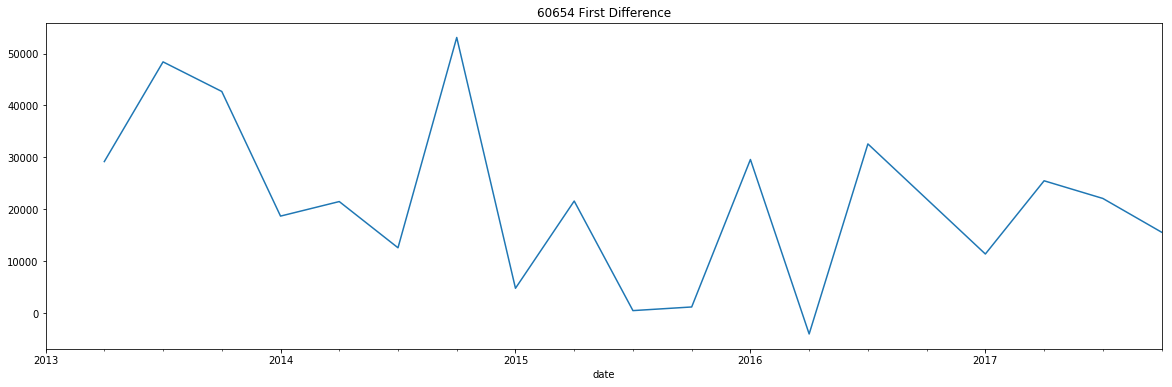

Test Statistic                 -4.354705
p-value                         0.000357
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Values (1%)           -3.859073
Critical Values (5%)           -3.042046
Critical Values (10%)          -2.660906
dtype: float64


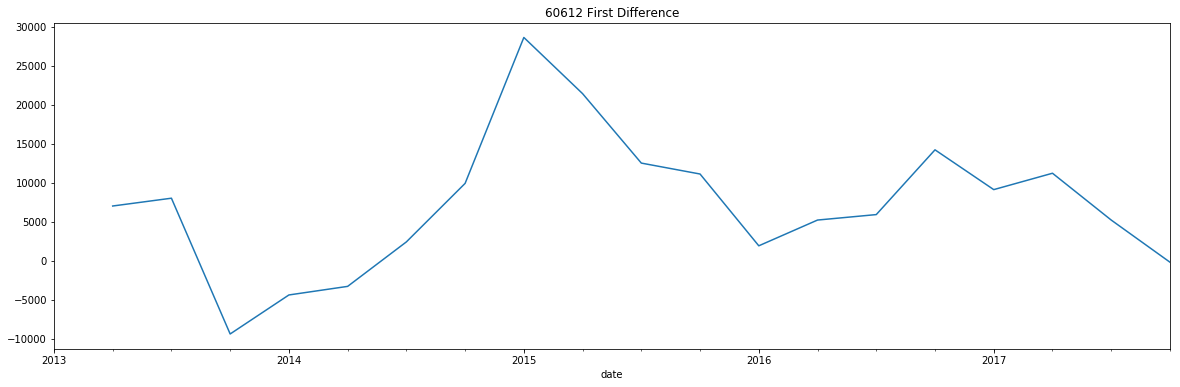

Test Statistic                 -3.274384
p-value                         0.016063
#Lags Used                      2.000000
Number of Observations Used    16.000000
Critical Values (1%)           -3.924019
Critical Values (5%)           -3.068498
Critical Values (10%)          -2.673893
dtype: float64


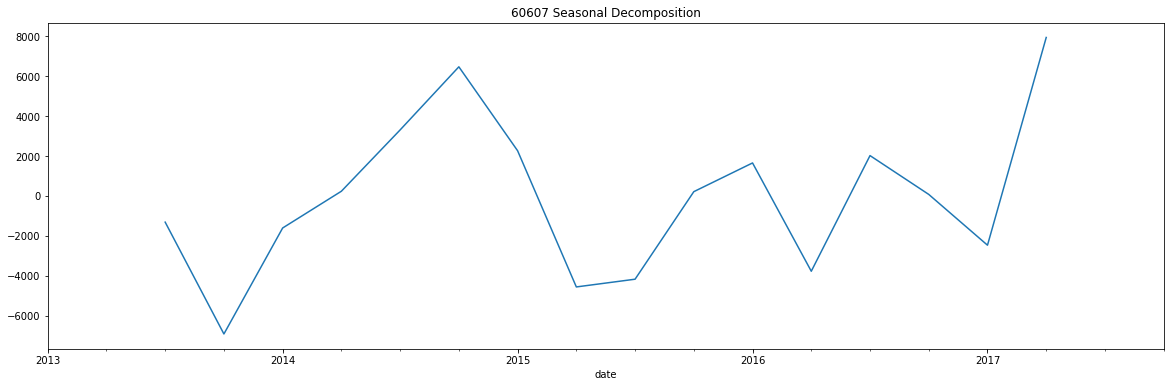

Test Statistic                 -3.255199
p-value                         0.017004
#Lags Used                      3.000000
Number of Observations Used    12.000000
Critical Values (1%)           -4.137829
Critical Values (5%)           -3.154972
Critical Values (10%)          -2.714477
dtype: float64


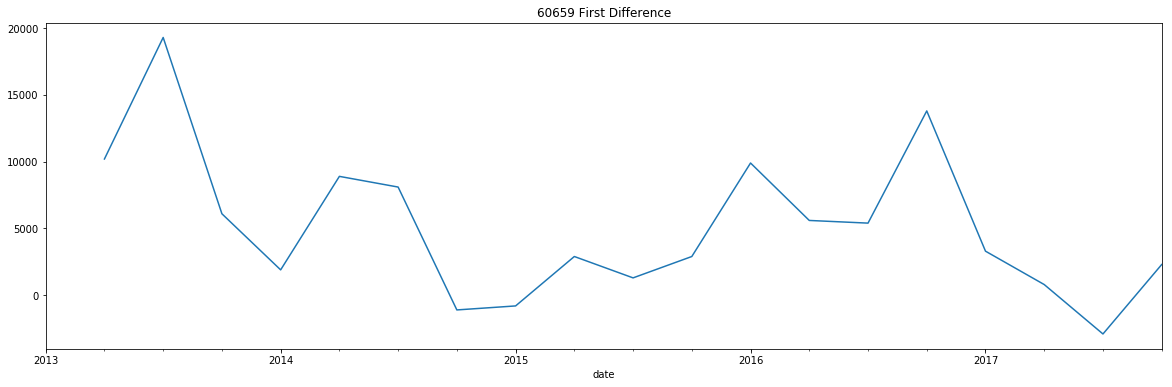

Test Statistic                 -2.922201
p-value                         0.042827
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Values (1%)           -3.859073
Critical Values (5%)           -3.042046
Critical Values (10%)          -2.660906
dtype: float64


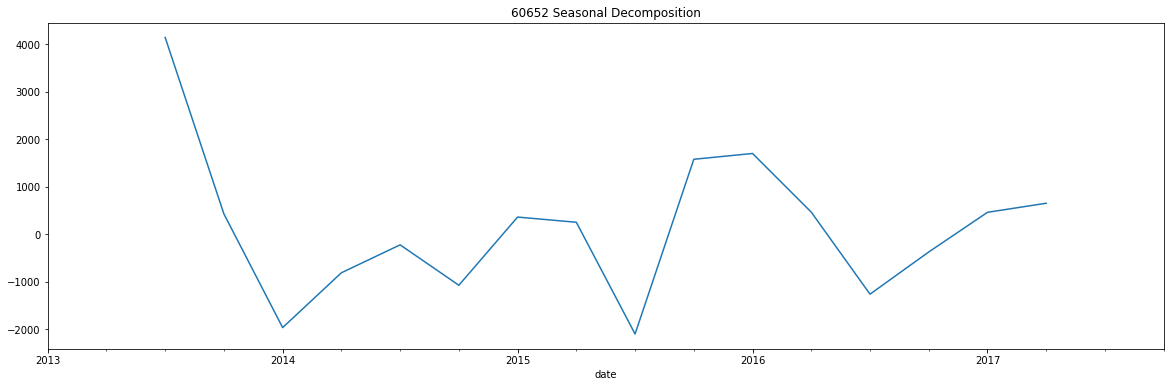

Test Statistic                 -4.477421
p-value                         0.000216
#Lags Used                      1.000000
Number of Observations Used    14.000000
Critical Values (1%)           -4.012034
Critical Values (5%)           -3.104184
Critical Values (10%)          -2.690987
dtype: float64


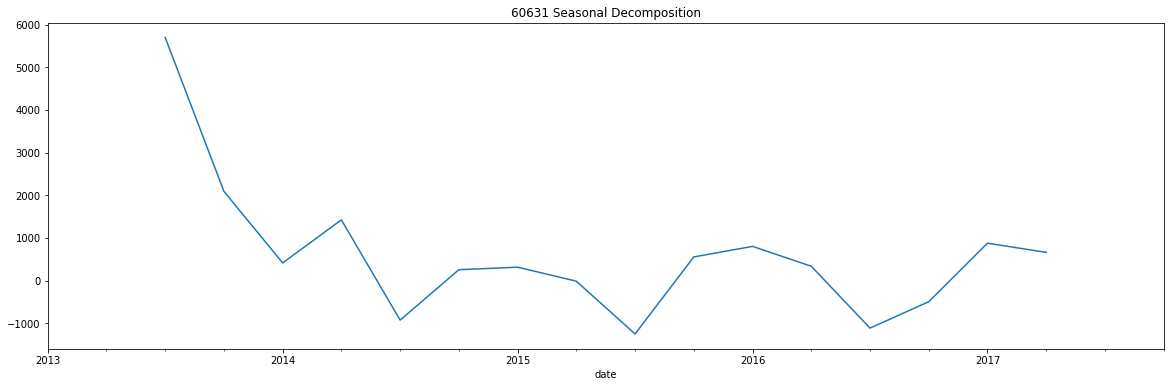

Test Statistic                -6.906052e+00
p-value                        1.246478e-09
#Lags Used                     3.000000e+00
Number of Observations Used    1.200000e+01
Critical Values (1%)          -4.137829e+00
Critical Values (5%)          -3.154972e+00
Critical Values (10%)         -2.714477e+00
dtype: float64


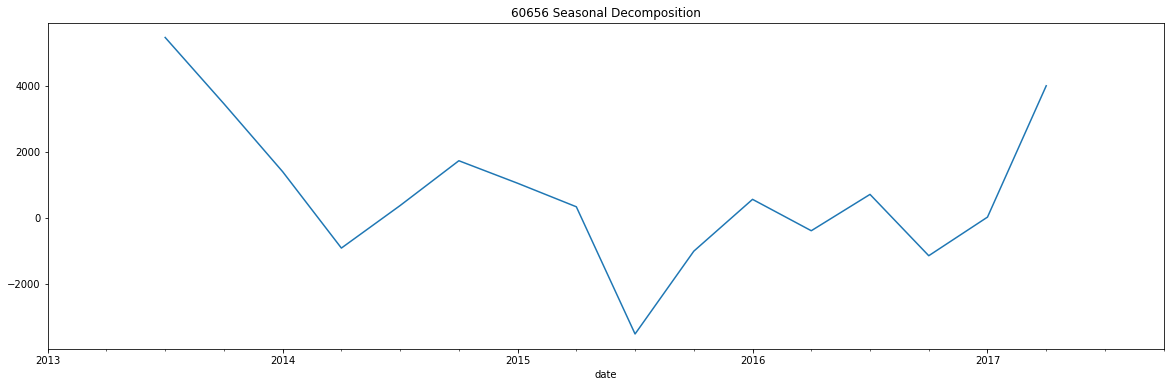

Test Statistic                 -2.822346
p-value                         0.055152
#Lags Used                      0.000000
Number of Observations Used    15.000000
Critical Values (1%)           -3.964443
Critical Values (5%)           -3.084908
Critical Values (10%)          -2.681814
dtype: float64


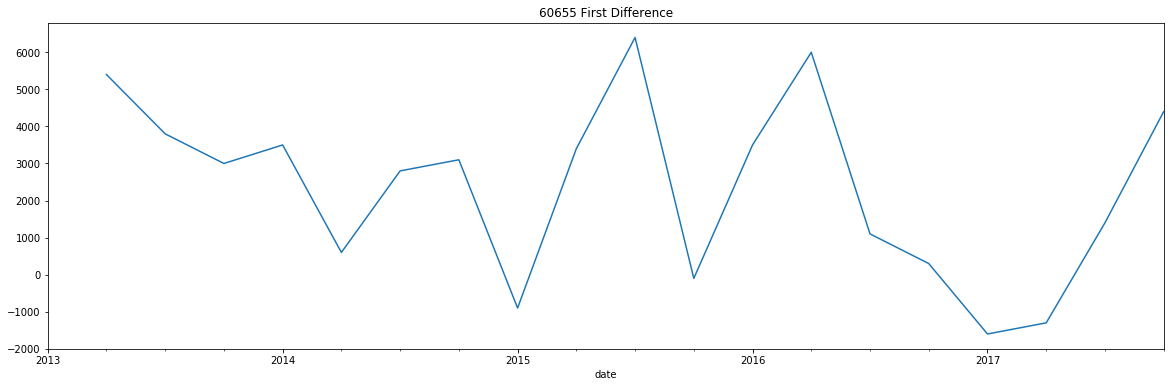

Test Statistic                 -2.937516
p-value                         0.041156
#Lags Used                      3.000000
Number of Observations Used    15.000000
Critical Values (1%)           -3.964443
Critical Values (5%)           -3.084908
Critical Values (10%)          -2.681814
dtype: float64


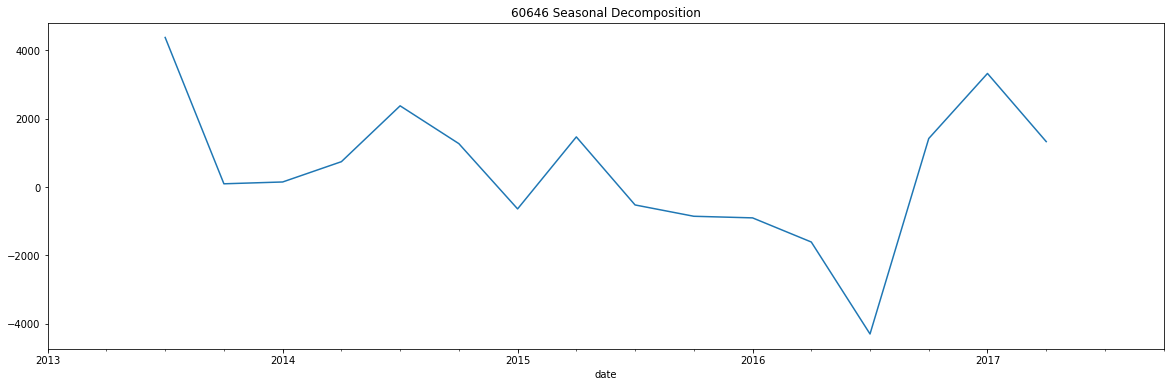

Test Statistic                 -3.337279
p-value                         0.013292
#Lags Used                      0.000000
Number of Observations Used    15.000000
Critical Values (1%)           -3.964443
Critical Values (5%)           -3.084908
Critical Values (10%)          -2.681814
dtype: float64


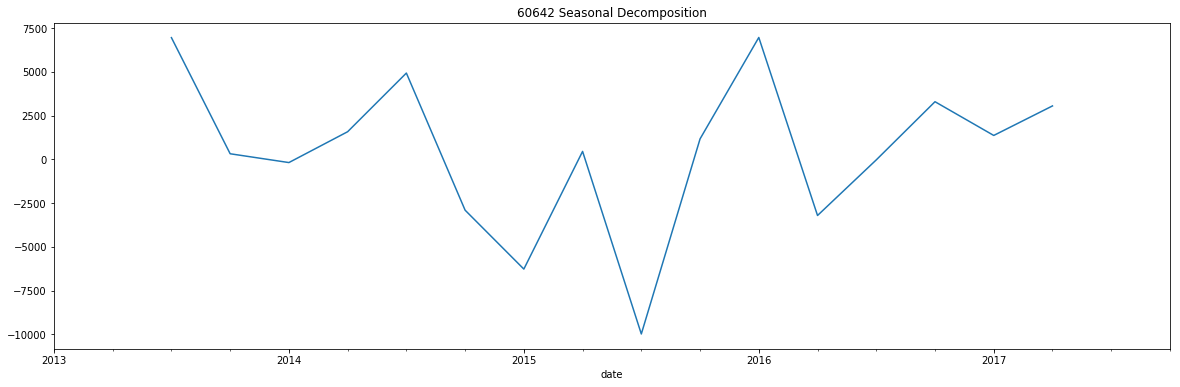

Test Statistic                 -4.011751
p-value                         0.001350
#Lags Used                      0.000000
Number of Observations Used    15.000000
Critical Values (1%)           -3.964443
Critical Values (5%)           -3.084908
Critical Values (10%)          -2.681814
dtype: float64


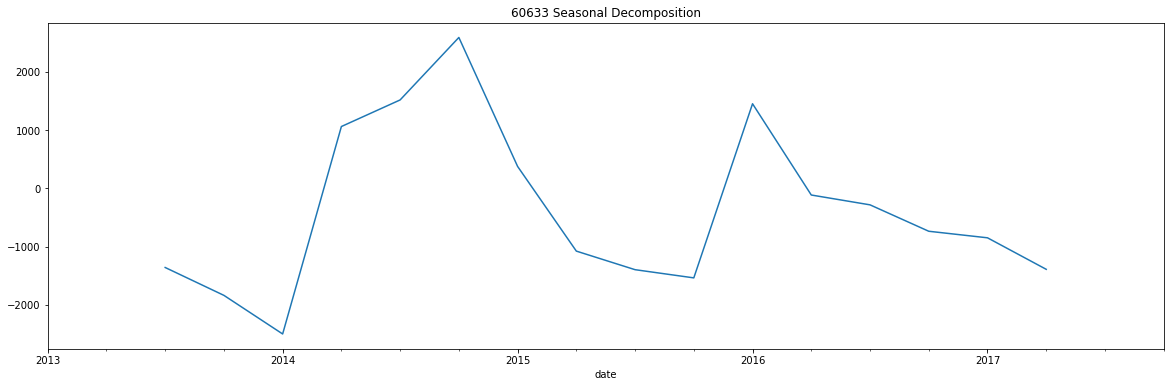

Test Statistic                 -4.794459
p-value                         0.000056
#Lags Used                      2.000000
Number of Observations Used    13.000000
Critical Values (1%)           -4.068854
Critical Values (5%)           -3.127149
Critical Values (10%)          -2.701730
dtype: float64

 The p-value above 0.1: 2


In [154]:
test = detrend(chicago_q,0.1)

In [155]:
test.head(20)

60657     60614     60640       60647      60618  \
date                                                                 
2013-01-01          NaN       NaN       NaN         NaN        NaN   
2013-04-01          NaN  0.038891       NaN         NaN        NaN   
2013-07-01  10983.59375  0.050149       NaN  6072.65625  3989.0625   
2013-10-01  -3200.78125  0.029258       NaN  -214.84375  1482.8125   
2014-01-01  -4444.53125  0.005681       NaN -2008.59375  1576.5625   
2014-04-01   5286.71875  0.010921       NaN -2499.21875   576.5625   
2014-07-01   5721.09375  0.011825       NaN -1589.84375  2776.5625   
2014-10-01  -4975.78125  0.001362       NaN -1114.84375 -1867.1875   
2015-01-01  -3419.53125  0.000765       NaN   441.40625 -2135.9375   
2015-04-01   1761.71875  0.013928       NaN   538.28125   -48.4375   
2015-07-01  -8491.40625  0.006101       NaN -6277.34375 -3648.4375   
2015-10-01   3574.21875  0.015214       NaN -2039.84375 -4642.1875   
2016-01-01   5192.96875  0.013692       NaN  2341.40625  -848.4375   
2016-04-01   3511.71875  0.009105 -0.050932  3600.78125   101.5625   
2016-07-01  -6303.90625 -0.000562 -0.023726  2135.15625  -160.9375   
2016-10-01   6511.71875  0.011887  0.011343  3710.15625  7982.8125   
2017-01-01   4580.46875  0.012375  0.019475  -433.59375  4364.0625   
2017-04-01  -8650.78125  0.007336  0.016202 -1299.21875  2326.5625   
2017-07-01          NaN  0.001321 -0.049875         NaN        NaN   
2017-10-01          NaN  0.006888 -0.047202         NaN        NaN   

                 60613       60629     60625    60619       60610  ...  \
date                                                               ...   
2013-01-01         NaN         NaN       NaN      NaN         NaN  ...   
2013-04-01         NaN         NaN       NaN  -4300.0         NaN  ...   
2013-07-01  10185.9375  1332.03125  3193.750  -5000.0  23601.5625  ...   
2013-10-01  -1889.0625    -2.34375  2600.000  -3900.0  12585.9375  ...   
2014-01-01  -4839.0625 -1224.21875  1034.375   4900.0   8932.8125  ...   
2014-04-01   3342.1875  -592.96875  1846.875   6900.0  -3532.8125  ...   
2014-07-01   -126.5625  -805.46875  3156.250   8000.0  -6010.9375  ...   
2014-10-01  -2139.0625  -752.34375  -687.500    100.0   -189.0625  ...   
2015-01-01  -8814.0625  1650.78125 -3340.625   3600.0  -6104.6875  ...   
2015-04-01   -195.3125   757.03125 -1265.625   -300.0   3954.6875  ...   
2015-07-01  -1076.5625 -1342.96875   493.750  -3700.0   1201.5625  ...   
2015-10-01   1398.4375  -102.34375 -1375.000  -2200.0  -4314.0625  ...   
2016-01-01   8910.9375   138.28125    -3.125  -4600.0  -3267.1875  ...   
2016-04-01   1167.1875   232.03125 -1278.125   1700.0   4367.1875  ...   
2016-07-01  -8626.5625   632.03125 -5043.750    600.0 -10235.9375  ...   
2016-10-01   2985.9375   672.65625  1262.500  10700.0    473.4375  ...   
2017-01-01   5098.4375  -749.21875  4109.375   4300.0   8995.3125  ...   
2017-04-01  -3957.8125  -580.46875  2496.875   -200.0   3767.1875  ...   
2017-07-01         NaN         NaN       NaN   1100.0         NaN  ...   
2017-10-01         NaN         NaN       NaN  -1100.0         NaN  ...   

              60612       60607    60659       60652       60631      60656  \
date                                                                          
2013-01-01      NaN         NaN      NaN         NaN         NaN        NaN   
2013-04-01   7000.0         NaN  10200.0         NaN         NaN        NaN   
2013-07-01   8000.0 -1314.84375  19300.0  4138.28125  5697.65625  5454.6875   
2013-10-01  -9400.0 -6924.21875   6100.0   425.78125  2091.40625  3448.4375   
2014-01-01  -4400.0 -1608.59375   1900.0 -1964.84375   413.28125  1392.1875   
2014-04-01  -3300.0   235.15625   8900.0  -811.71875  1422.65625  -920.3125   
2014-07-01   2400.0  3310.15625   8100.0  -224.21875  -927.34375   367.1875   
2014-10-01   9900.0  6475.78125  -1100.0 -1074.21875   253.90625  1723.4375   
2015-01-01  28600.0  2266.40625   -800.0   360.15625   313

The nan's are because we took the differences (sometimes twice). 

In [159]:
# plist = []
# [detrend(chicago_q,x) for x in list(chicago_q.columns)]

In [160]:
(np.array(plist)>0.1).sum()

0

In [161]:
def ACF_PACF(TS, lags):
    for column in list(TS.columns):
        print(column)
        pd.plotting.autocorrelation_plot(TS[column])
        plt.title('Autocorrelation Function')
        plt.show()
        from statsmodels.graphics.tsaplots import plot_pacf
        from matplotlib.pylab import rcParams
        rcParams['figure.figsize']=14,5
        plot_pacf(TS[column], lags=lags)
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.show()
        print('_____________________________________________________________________')

In [261]:
# ACF_PACF(test,5);

### From the plots, we can conclude an AR model with one lag would be an appropriate model to fit the data. 

### To Do:

- Limit the zipcodes (pick, but choose different behaving groups to get some insight). Communicate the limitation of the function. Within the time constraints of the project we tried a variety of methods to stabalize, we eliminated...
- What is the baseline model? 
- Add more differencing methods. 
- Prediction intervals
- fix autocorrelation and correlation function 
- Make sure you are not overfitting, the more complex the model the more chances you are overfitting
- If the autocorrelation function dies slowly, you need to difference the difference in the series. 
- Test on the period you would like to predict for, so 6-months. Use other zipcodes in the group as extra testing. 